## KOH2: Sieć Kohonena na siatce sześciokątnej

Do implementacji z zeszłego tygodnia dodać możliwość ułożenia neuronów w topologii siatki sześciokątnej.

Zastosować oba warianty topologii i obie funkcje sąsiedztwa do wektorów danych ze zbiorów

- MNIST  
- https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones  

(sieć Kohonena uruchomić na zbiorach bez etykiet!).

Przeanalizować otrzymane mapowanie danych uwzględniając etykiety danych. Jak dobrze znalezione klastry odpowiadają podziałowi na klasy?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def gaussian_neighborhood(distance, sigma):
    return np.exp(-distance**2 / (2 * sigma**2))

def second_derivative_gaussian(distance, sigma):
    return -gaussian_neighborhood(distance, sigma) * (distance**2 - sigma**2) / sigma**4

def offset_to_cube(i, j):
    x = j - (i - (i & 1)) // 2
    z = i
    y = -x - z
    return np.array([x, y, z])

def hex_distance(a, b):
    return max(np.abs(a - b))

class KohonenNetwork:
    def __init__(self, M, N, input_dim, learning_rate=0.1, neighborhood_function='gaussian', sigma=1.0, lambda_decay=1000):
        self.neighborhood_functions = {
            'gaussian': gaussian_neighborhood,
            'second_derivative_gaussian': second_derivative_gaussian,
        }

        self.neighborhood_function = self.neighborhood_functions[neighborhood_function]

        self.M, self.N = M, N
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.lambda_decay = lambda_decay
        self.weights = np.random.rand(M, N, input_dim)

    def decay_learning_rate(self, t):
        return np.exp(-t / self.lambda_decay)

    def find_bmu(self, input_vector):
        distances = np.linalg.norm(self.weights - input_vector, axis=2)
        bmu_index = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_index, distances

    def update_weights(self, input_vector, t, topology_type='matrix'):
        learning_rate = self.decay_learning_rate(t)
        bmu, _ = self.find_bmu(input_vector)

        for i in range(self.M):
            for j in range(self.N):
                if topology_type == 'matrix':
                    distance = np.linalg.norm(np.array([i, j]) - np.array(bmu))
                elif topology_type == 'hex':
                    coord_a = offset_to_cube(i, j)
                    coord_b = offset_to_cube(*bmu)
                    distance = hex_distance(coord_a, coord_b)
                else:
                    raise ValueError("Invalid topology_type. Use 'matrix' or 'hex'.")

                influence = self.neighborhood_function(distance, self.sigma)
                self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])

    def train(self, data, epochs, topology_type='matrix'):
        for t in range(epochs):
            input_vector = data[np.random.randint(0, data.shape[0])]
            self.update_weights(input_vector, t, topology_type=topology_type)


    def get_cluster_assignments(self, data, assign=0):
        clusters = []
        cluster_positions = []
        for sample in data:
            bmu, _ = self.find_bmu(sample)
            cluster_number = bmu[0] * self.N + bmu[1]
            clusters.append(cluster_number)
            cluster_positions.append(bmu)
        if assign == 1:

            return np.array(clusters), np.array(cluster_positions)
        
        return np.array(clusters)



In [ ]:
def show_results(network, X, y, X_test, y_test):
    from collections import defaultdict, Counter

    def get_cluster_to_labels(data, labels):
        preds = network.get_cluster_assignments(data)
        cluster_to_labels = defaultdict(list)
        for pred, label in zip(preds, labels):
            cluster_to_labels[pred].append(label)
        return preds, cluster_to_labels

    def plot_cluster_distribution(cluster_to_labels, title, y_labels):
        sorted_clusters = sorted(cluster_to_labels.keys())
        x = np.arange(len(sorted_clusters))

        cluster_class_counts_sorted = []
        for cluster in sorted_clusters:
            counts = Counter(cluster_to_labels[cluster]).most_common()
            cluster_class_counts_sorted.append(counts)

        all_classes = sorted(set(y_labels))
        cmap = plt.get_cmap("tab10")
        color_map = {cls: cmap(i % 10) for i, cls in enumerate(all_classes)}

        plt.figure(figsize=(10, 8))
        bottoms = np.zeros(len(sorted_clusters))

        max_depth = max(len(c) for c in cluster_class_counts_sorted)
        for level in range(max_depth):
            heights = []
            labels = []
            for c in cluster_class_counts_sorted:
                if level < len(c):
                    cls, count = c[level]
                    heights.append(count)
                    labels.append(cls)
                else:
                    heights.append(0)
                    labels.append(None)

            for cls in set(l for l in labels if l is not None):
                h = [heights[i] if labels[i] == cls else 0 for i in range(len(labels))]
                plt.bar(x, h, bottom=bottoms, color=color_map[cls], label=f"Klasa {cls}" if level == 0 else "", edgecolor='black', linewidth=0.3)
                bottoms += h

        plt.xticks(x, sorted_clusters)
        plt.xlabel("Numer klastra (neuronu)")
        plt.ylabel("Liczba próbek")
        plt.title(title)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), title="Klasy")
        plt.tight_layout()
        plt.show()

    train_preds, cluster_to_labels_train = get_cluster_to_labels(X, y)
    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels_train.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in train_preds])
    accuracy_train = np.mean(mapped_preds == y)
    print("Dopasowana accuracy (trening):", accuracy_train)

    unique_clusters = np.unique(train_preds)
    unique_classes = np.unique(y)

    print(f"Liczba klastrów: {len(unique_clusters)}")
    print(f"Liczba klas: {len(unique_classes)}")
    if len(unique_clusters) == len(unique_classes):
        print("Liczba klastrów pokrywa się z liczbą klas.")
    else:
        print("Liczba klastrów nie pokrywa się z liczbą klas.")

    plot_cluster_distribution(cluster_to_labels_train,
                              "Skumulowany rozkład klas w klastrach — trening",
                              y)

    M, N = network.M, network.N
    label_grid = np.full((M, N), -1)
    for i in range(M):
        for j in range(N):
            cluster = i * N + j
            if cluster in mapping:
                label_grid[i, j] = mapping[cluster]

    plt.figure(figsize=(8, 8))
    plt.imshow(label_grid, cmap='tab10', interpolation='nearest')
    plt.title("Dominująca klasa przypisana do każdego neuronu SOM (trening)")
    plt.colorbar()
    plt.show()

    test_preds = network.get_cluster_assignments(X_test)
    mapped_test_preds = np.array([mapping.get(p, -1) for p in test_preds])
    accuracy_test = np.mean(mapped_test_preds == y_test)
    print("Accuracy na zbiorze testowym:", accuracy_test)

    cluster_to_labels_test = defaultdict(list)
    for pred, label in zip(test_preds, y_test):
        cluster_to_labels_test[pred].append(label)

    plot_cluster_distribution(cluster_to_labels_test,
                              "Skumulowany rozkład klas w klastrach — test",
                              y_test)


## MNIST

### znalezienie odpowiedniej sigmy

c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\Users\okroj\AppData\Local\Temp\ipykernel_20620\3723045953.py:60: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])
C:\Users\okroj\AppData\Local\Temp\ipykernel_20620\3723045953.py:60: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.1     accuracy =  0.11236666666666667


C:\Users\okroj\AppData\Local\Temp\ipykernel_20620\3723045953.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.11236666666666667
sigma =  1.09     accuracy =  0.29915
sigma =  1.585     accuracy =  0.37246666666666667
sigma =  2.08     accuracy =  0.38615
sigma =  2.575     accuracy =  0.3741
sigma =  3.07     accuracy =  0.3818
sigma =  3.565     accuracy =  0.3942333333333333
sigma =  4.06     accuracy =  0.3743166666666667
sigma =  4.555     accuracy =  0.3389666666666667
sigma =  5.05     accuracy =  0.3259666666666667
sigma =  5.545     accuracy =  0.3038666666666667
sigma =  6.039999999999999     accuracy =  0.29496666666666665
sigma =  6.534999999999999     accuracy =  0.27545
sigma =  7.029999999999999     accuracy =  0.26253333333333334
sigma =  7.5249999999999995     accuracy =  0.2517
sigma =  8.02     accuracy =  0.2516333333333333
sigma =  8.514999999999999     accuracy =  0.2617333333333333
sigma =  9.01     accuracy =  0.24713333333333334
sigma =  9.504999999999999     accuracy =  0.24066666666666667
sigma =  10.0     accuracy =  0.246366666666666

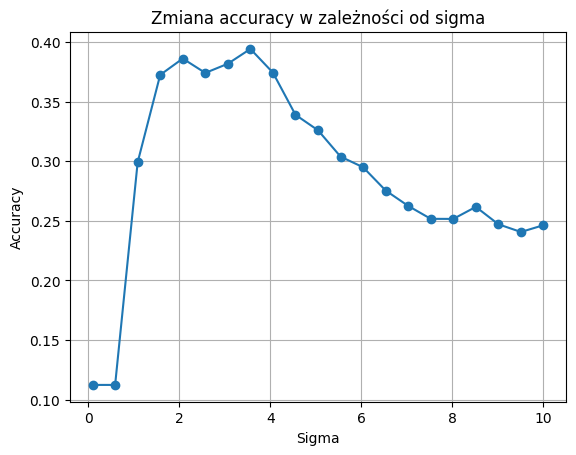

In [ ]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='hex')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds]) 
    accuracy = np.mean(mapped_preds == y) 
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\Users\okroj\AppData\Local\Temp\ipykernel_20620\3723045953.py:60: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])
C:\Users\okroj\AppData\Local\Temp\ipykernel_20620\3723045953.py:60: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.1     accuracy =  0.11236666666666667


C:\Users\okroj\AppData\Local\Temp\ipykernel_20620\3723045953.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.11236666666666667
sigma =  1.09     accuracy =  0.20803333333333332
sigma =  1.585     accuracy =  0.3668
sigma =  2.08     accuracy =  0.39873333333333333
sigma =  2.575     accuracy =  0.38493333333333335
sigma =  3.07     accuracy =  0.40136666666666665
sigma =  3.565     accuracy =  0.41205
sigma =  4.06     accuracy =  0.35536666666666666
sigma =  4.555     accuracy =  0.3964
sigma =  5.05     accuracy =  0.38805
sigma =  5.545     accuracy =  0.38383333333333336
sigma =  6.039999999999999     accuracy =  0.3731333333333333
sigma =  6.534999999999999     accuracy =  0.33405
sigma =  7.029999999999999     accuracy =  0.30705
sigma =  7.5249999999999995     accuracy =  0.3419
sigma =  8.02     accuracy =  0.28135
sigma =  8.514999999999999     accuracy =  0.30838333333333334
sigma =  9.01     accuracy =  0.28501666666666664
sigma =  9.504999999999999     accuracy =  0.28878333333333334
sigma =  10.0     accuracy =  0.29001666666666664


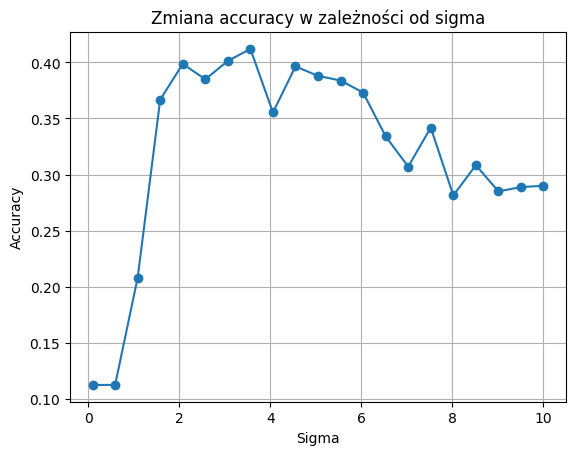

In [ ]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='matrix')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


sigma =  0.1     accuracy =  0.6017666666666667
sigma =  0.595     accuracy =  0.5526
sigma =  1.09     accuracy =  0.45285
sigma =  1.585     accuracy =  0.37273333333333336
sigma =  2.08     accuracy =  0.40668333333333334
sigma =  2.575     accuracy =  0.3981166666666667
sigma =  3.07     accuracy =  0.3852
sigma =  3.565     accuracy =  0.35575
sigma =  4.06     accuracy =  0.3629833333333333
sigma =  4.555     accuracy =  0.3662166666666667
sigma =  5.05     accuracy =  0.36386666666666667
sigma =  5.545     accuracy =  0.2888833333333333
sigma =  6.039999999999999     accuracy =  0.3360666666666667
sigma =  6.534999999999999     accuracy =  0.2523
sigma =  7.029999999999999     accuracy =  0.24826666666666666
sigma =  7.5249999999999995     accuracy =  0.23895
sigma =  8.02     accuracy =  0.2517333333333333
sigma =  8.514999999999999     accuracy =  0.24745
sigma =  9.01     accuracy =  0.24431666666666665
sigma =  9.504999999999999     accuracy =  0.24696666666666667
sigma =  1

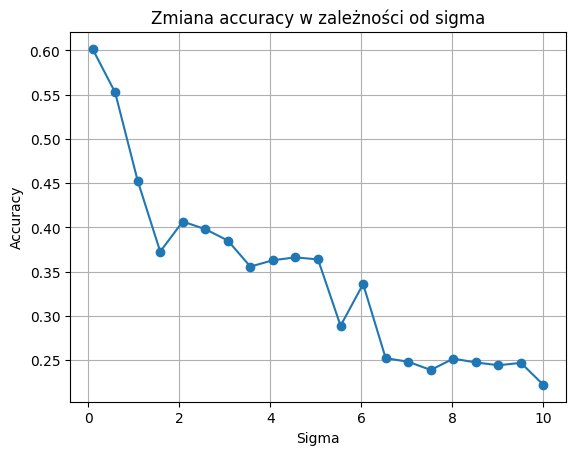

In [ ]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='matrix')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds]) 
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


sigma =  0.1     accuracy =  0.60265
sigma =  0.595     accuracy =  0.5505833333333333
sigma =  1.09     accuracy =  0.43141666666666667
sigma =  1.585     accuracy =  0.40098333333333336
sigma =  2.08     accuracy =  0.38548333333333334
sigma =  2.575     accuracy =  0.3227333333333333
sigma =  3.07     accuracy =  0.3113166666666667
sigma =  3.565     accuracy =  0.2623
sigma =  4.06     accuracy =  0.25256666666666666
sigma =  4.555     accuracy =  0.24655
sigma =  5.05     accuracy =  0.24248333333333333
sigma =  5.545     accuracy =  0.23148333333333335
sigma =  6.039999999999999     accuracy =  0.2331
sigma =  6.534999999999999     accuracy =  0.22923333333333334
sigma =  7.029999999999999     accuracy =  0.2272
sigma =  7.5249999999999995     accuracy =  0.22416666666666665
sigma =  8.02     accuracy =  0.22065
sigma =  8.514999999999999     accuracy =  0.22023333333333334
sigma =  9.01     accuracy =  0.2173
sigma =  9.504999999999999     accuracy =  0.21966666666666668
sigma =

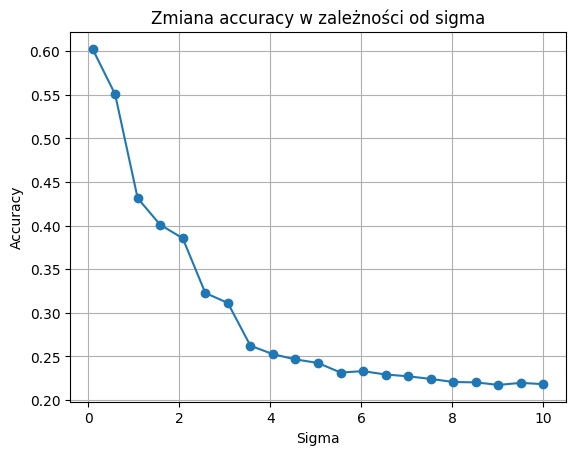

In [ ]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='hex')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds]) 
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy) 
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()

Dla funckji sąsiedztwa gaussian najlepsze wyniki są dla sigma = 0.1.

Zaś dla minus drugiej pochodnej gaussa najlepsza dokładność jest dla sigma ~ 3.

### gauss, matrix, 2x5,10x10,20x20

Dopasowana accuracy (trening): 0.5914
Liczba klastrów: 10
Liczba klas: 10
Liczba klastrów pokrywa się z liczbą klas.


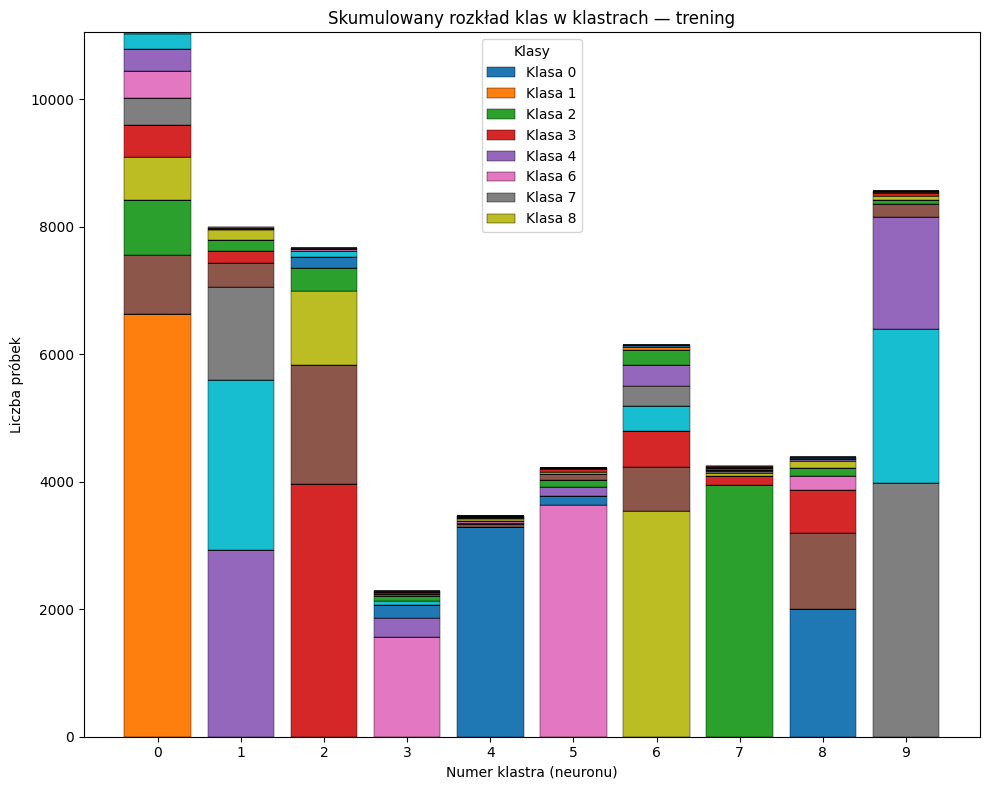

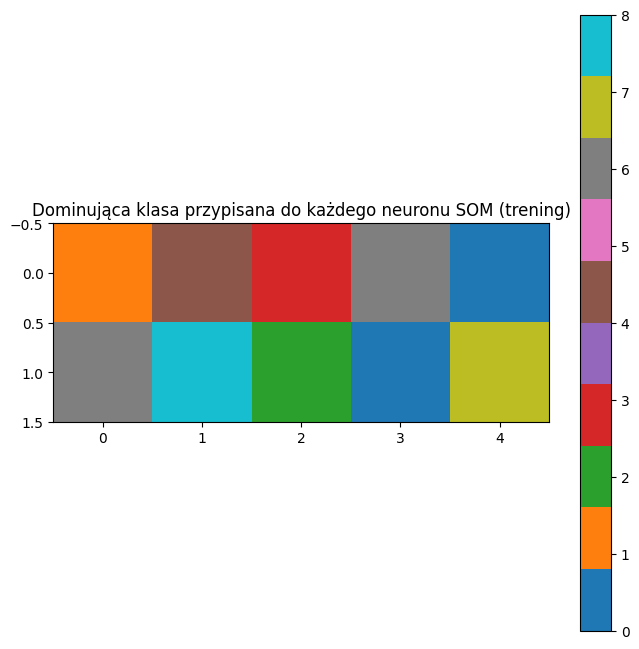

Accuracy na zbiorze testowym: 0.5909


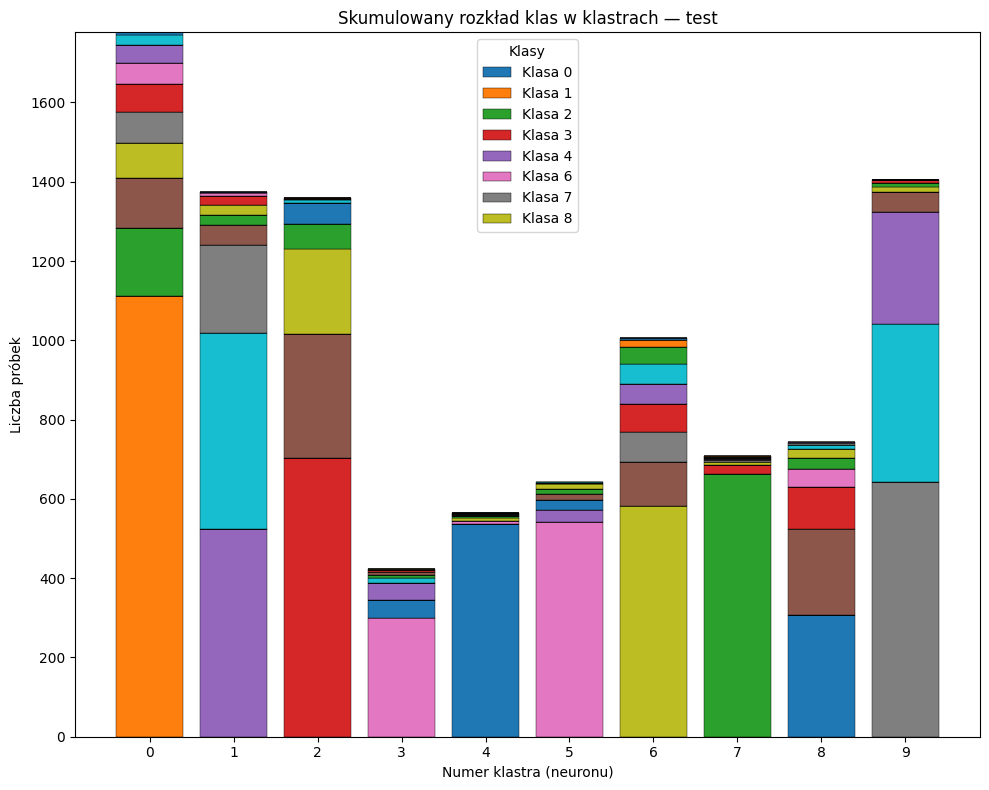

In [7]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="gaussian", sigma = 0.1)

network.train(X, epochs=10000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.7947166666666666
Liczba klastrów: 60
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


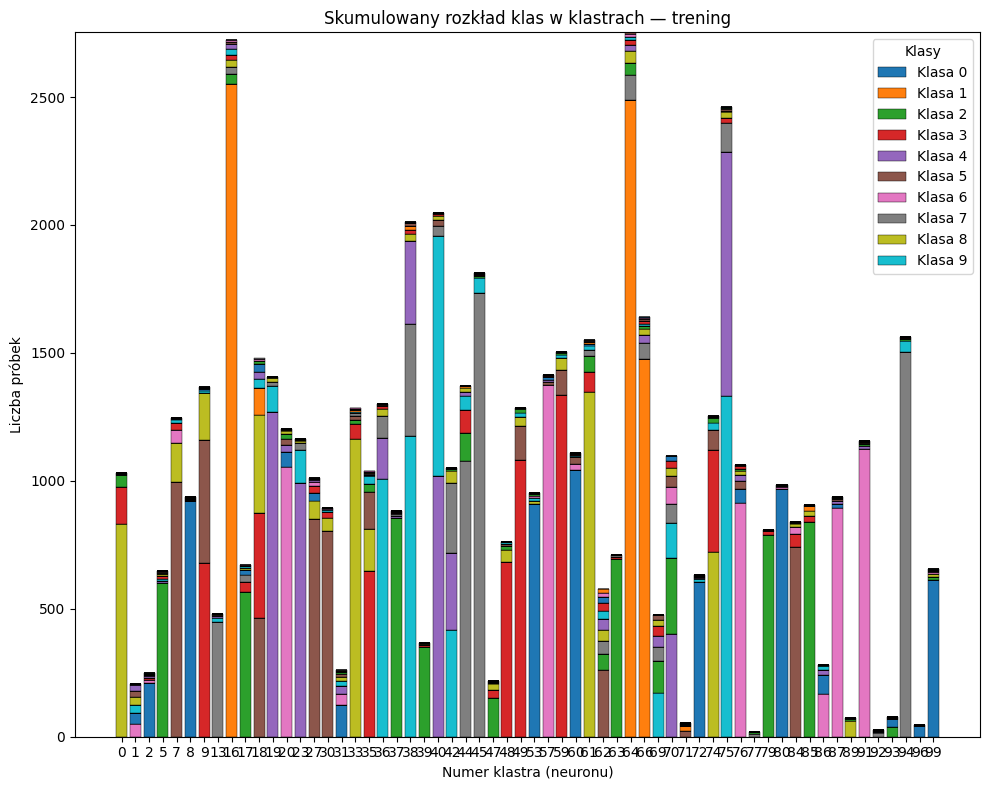

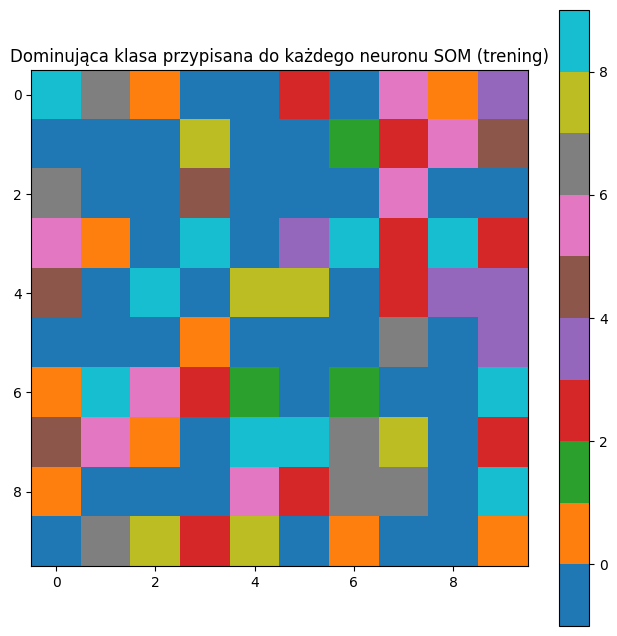

Accuracy na zbiorze testowym: 0.7957


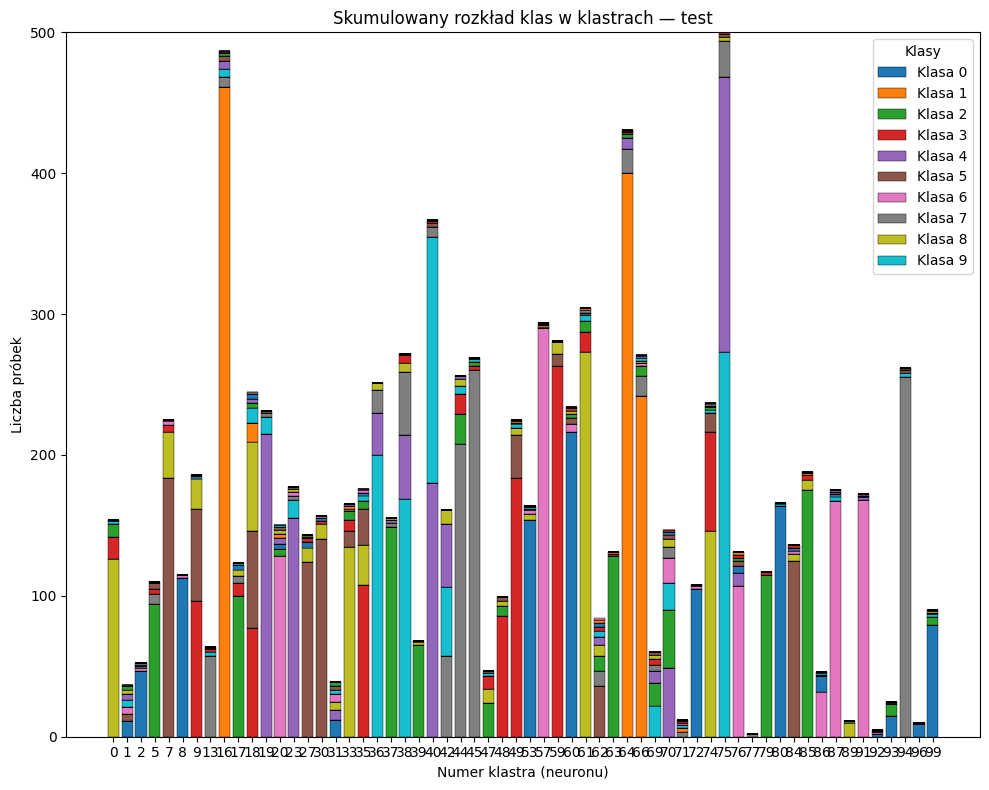

In [8]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=10, N=10, input_dim=784, neighborhood_function="gaussian", sigma = 0.1)

network.train(X, epochs=10000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.80005
Liczba klastrów: 58
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


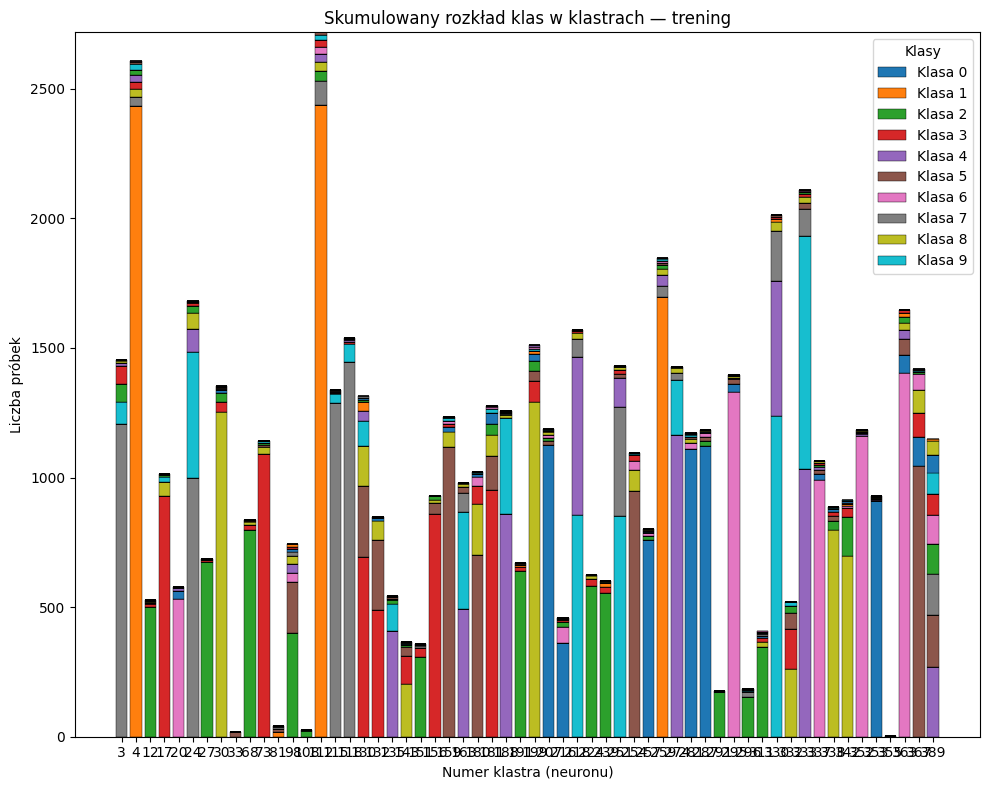

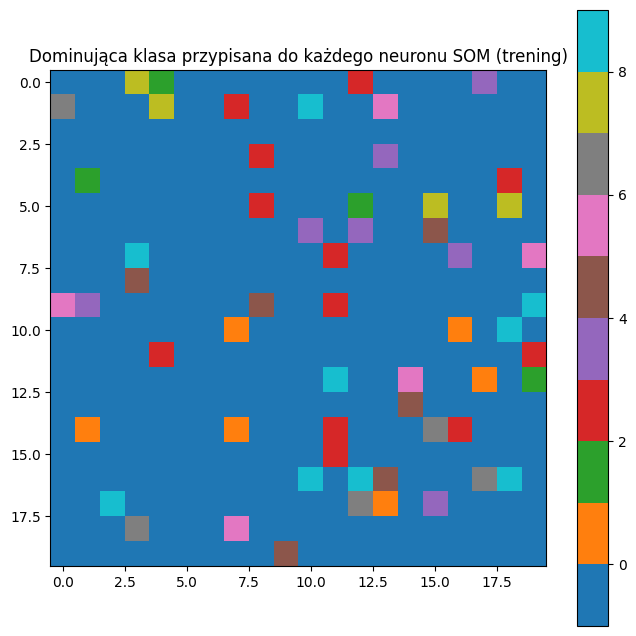

Accuracy na zbiorze testowym: 0.8109


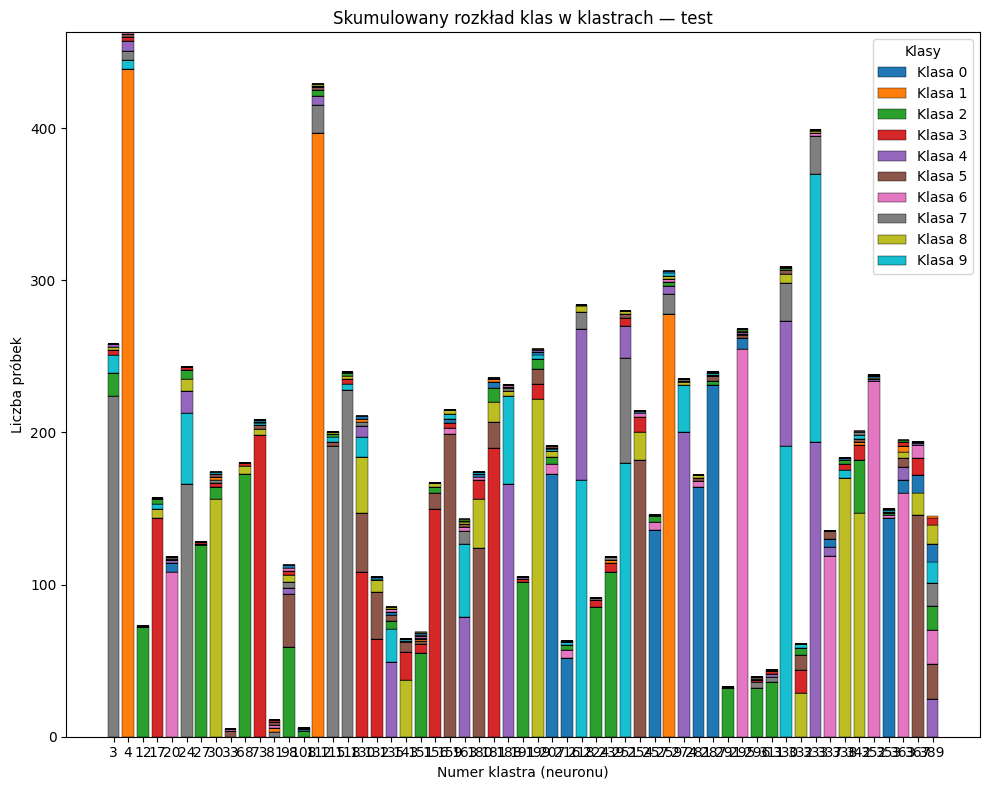

In [9]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=20, N=20, input_dim=784, neighborhood_function="gaussian", sigma = 0.1)

network.train(X, epochs=10000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| gauss              | matrix    | 0.1   | 2x5            | 0.5914         | 0.5909        | 10             |
| gauss              | matrix    | 0.1   | 10x10          | 0.7947         | 0.7957        |60              |
| gauss              | matrix    | 0.1   | 20x20          | 0.8001         | 0.8109        |58              |

### gauss, hex, 2x5,10x10,20x20

Dopasowana accuracy (trening): 0.6211833333333333
Liczba klastrów: 10
Liczba klas: 10
Liczba klastrów pokrywa się z liczbą klas.


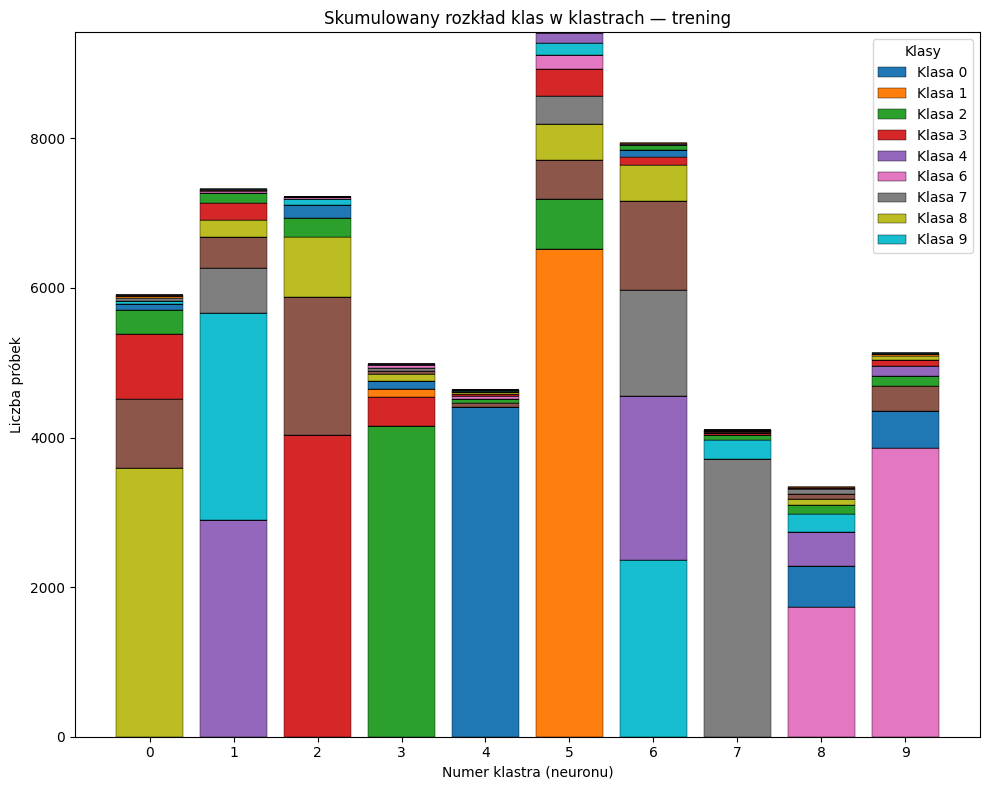

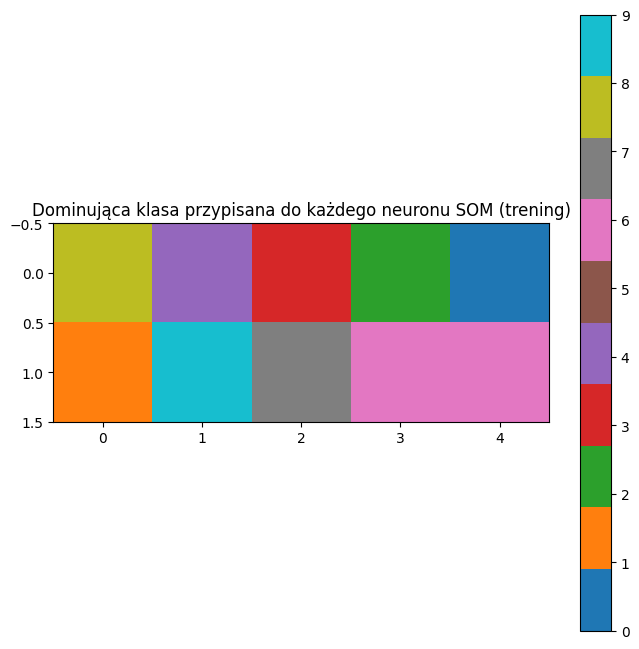

Accuracy na zbiorze testowym: 0.6264


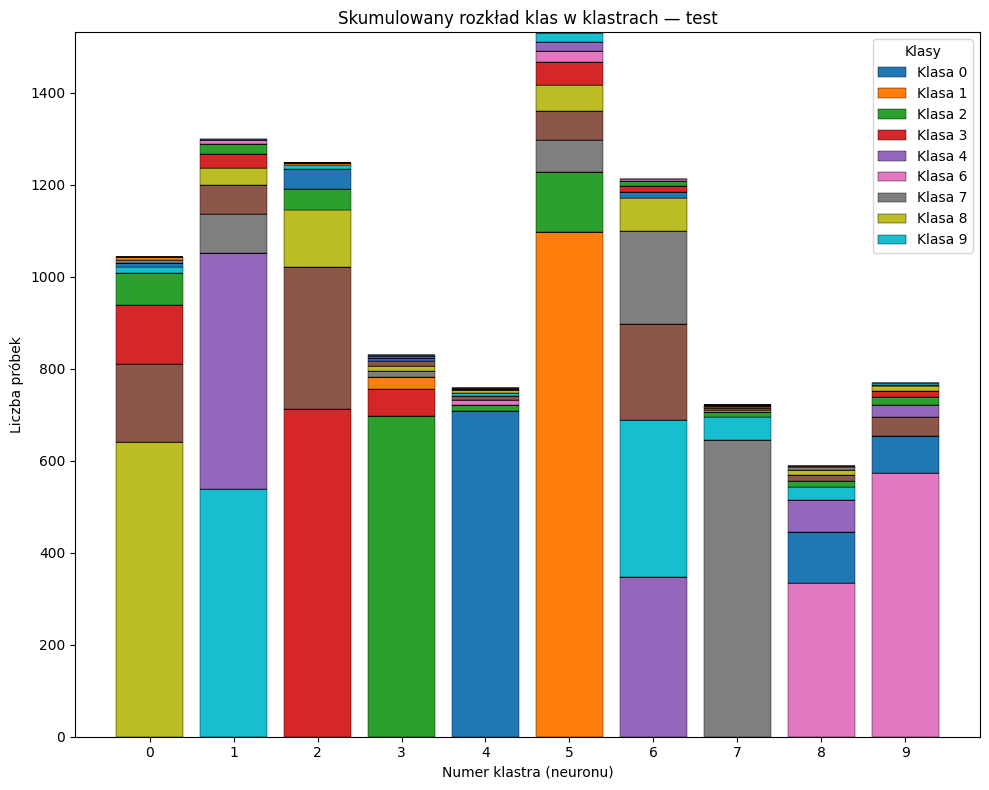

In [10]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="gaussian", sigma = 0.1)

network.train(X, epochs=10000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.78065
Liczba klastrów: 58
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


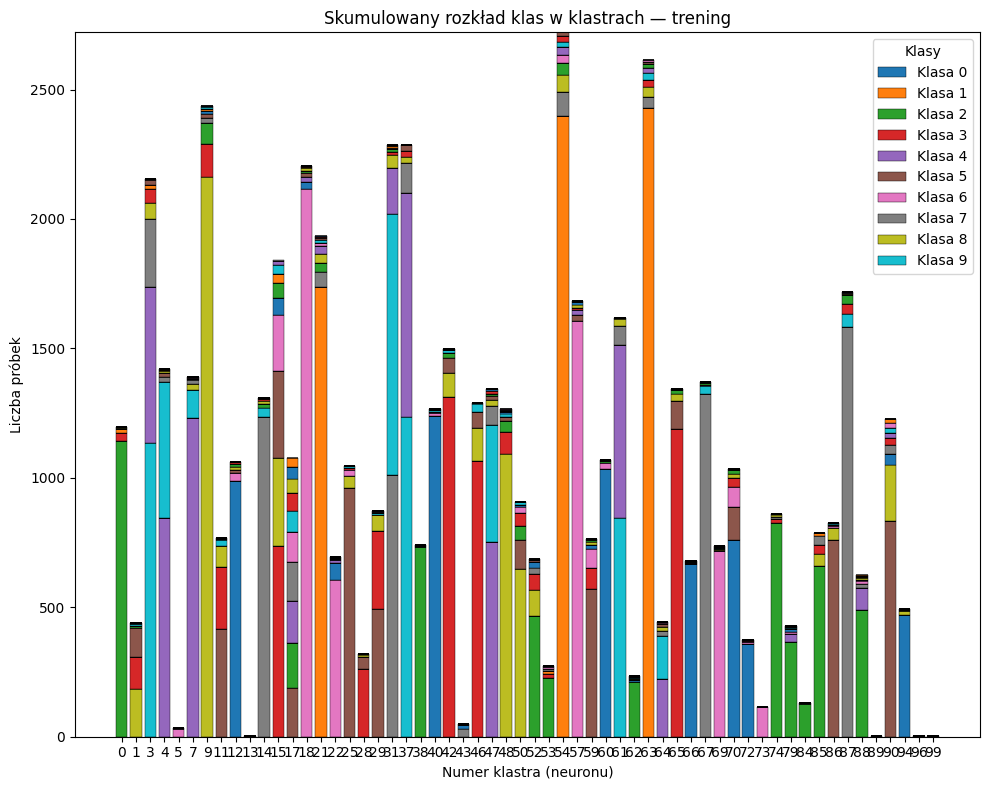

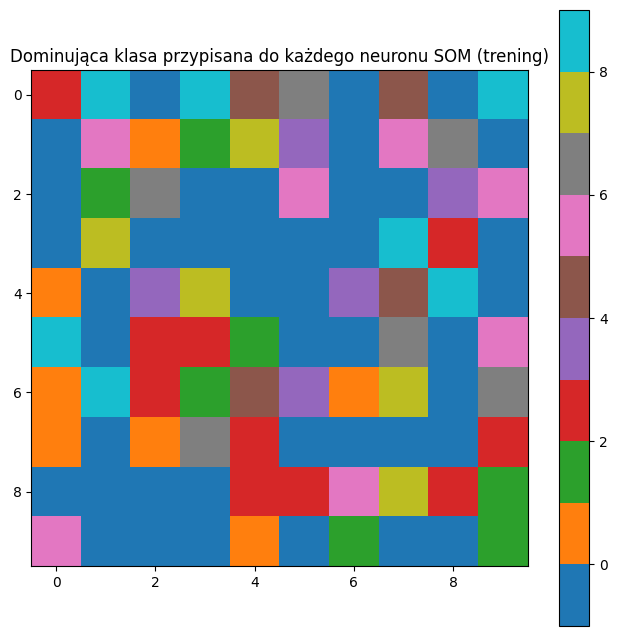

Accuracy na zbiorze testowym: 0.7916


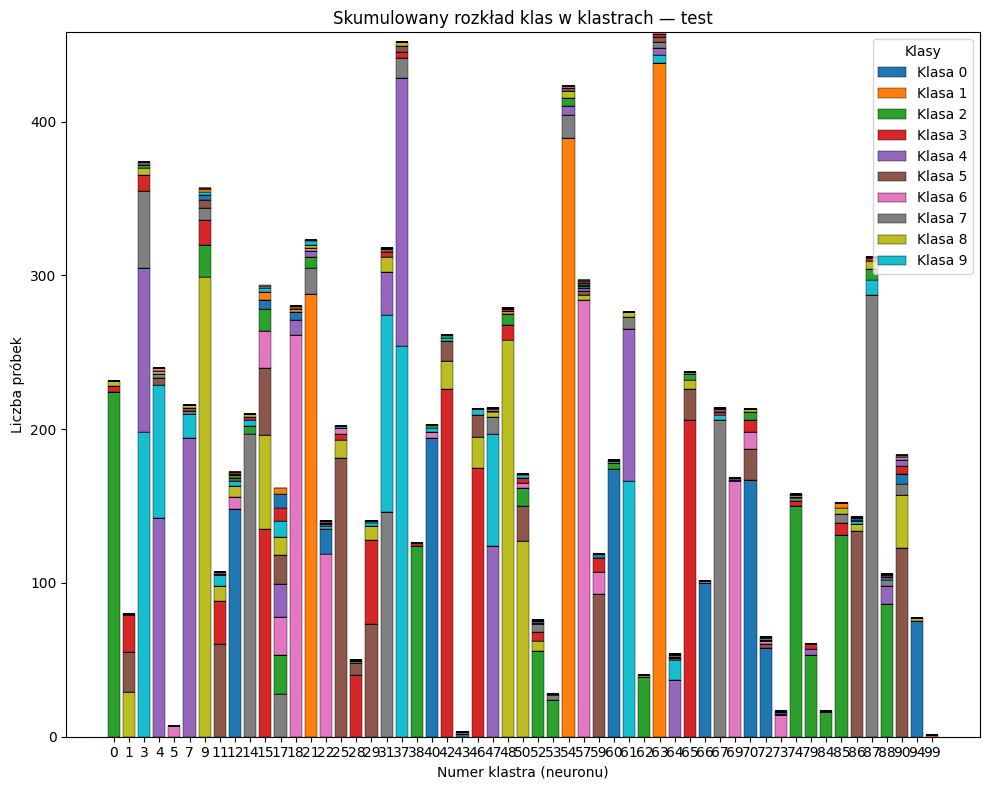

In [11]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=10, N=10, input_dim=784, neighborhood_function="gaussian", sigma = 0.1)

network.train(X, epochs=10000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.7672166666666667
Liczba klastrów: 60
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


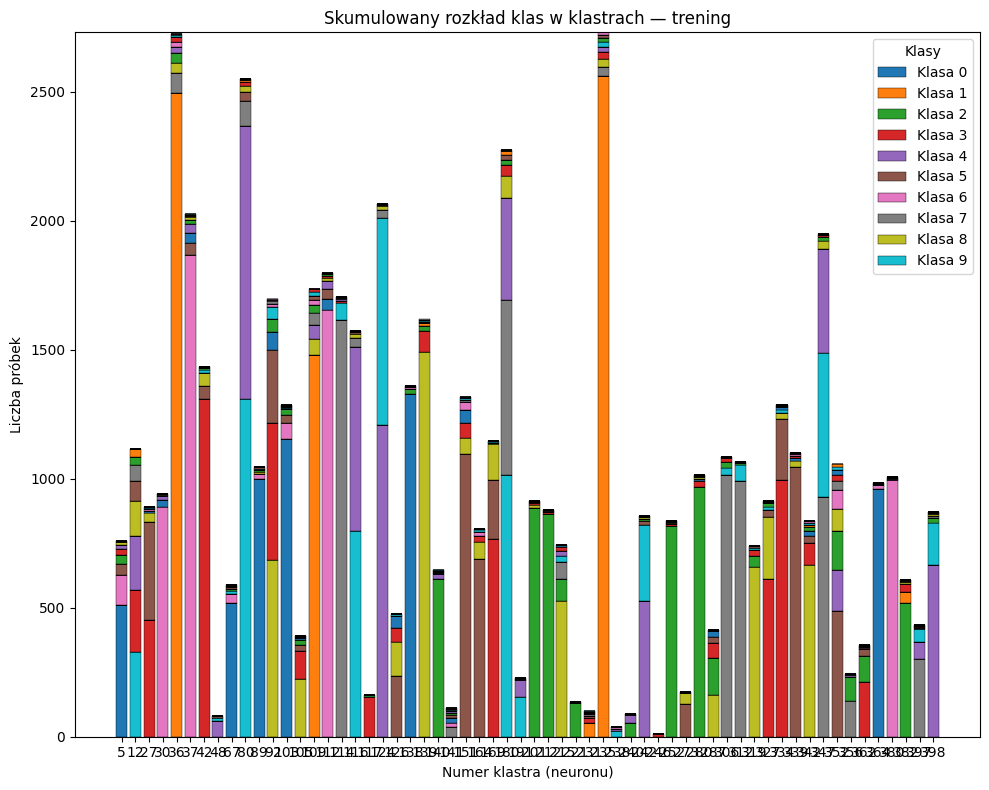

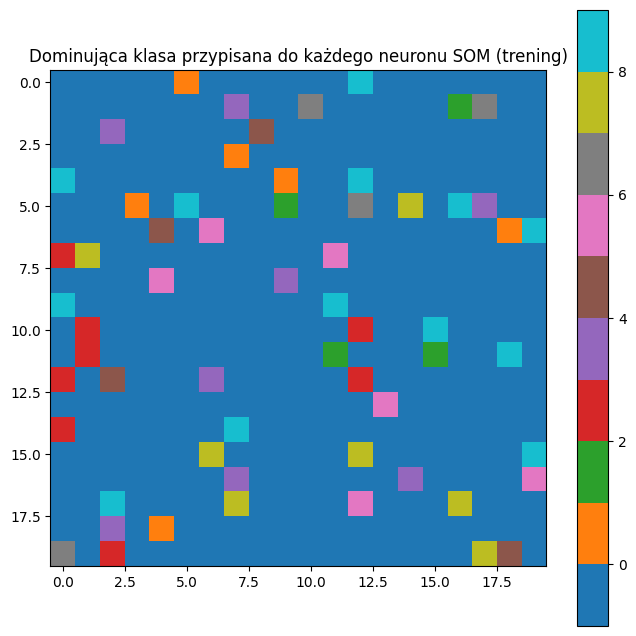

Accuracy na zbiorze testowym: 0.7772


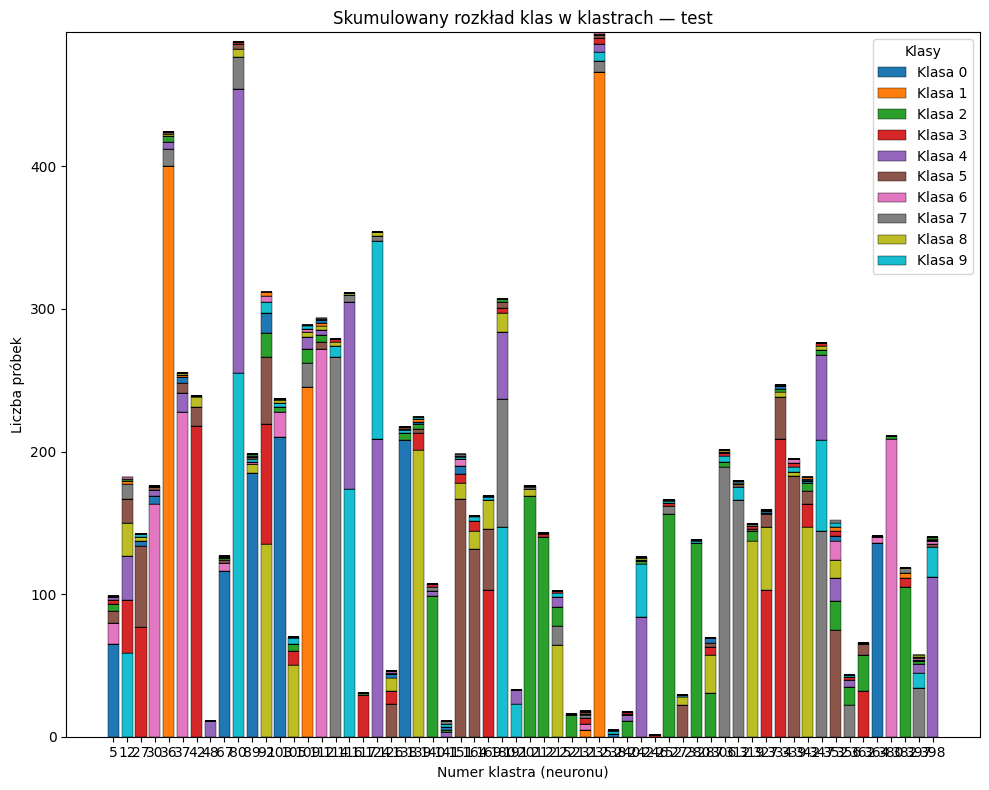

In [12]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=20, N=20, input_dim=784, neighborhood_function="gaussian", sigma = 0.1)

network.train(X, epochs=10000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| gauss              | hex       | 0.1   | 2x5            | 0.6212         | 0.6264        | 10             |
| gauss              | hex       | 0.1   | 10x10          | 0.78065        | 0.7916        | 58             |
| gauss              | hex       | 0.1   | 20x20          | 0.76722        | 0.7772        | 60             |

### Minus 2-gauss, matrix, 2x5,10x10,20x20

Dopasowana accuracy (trening): 0.40905
Liczba klastrów: 10
Liczba klas: 10
Liczba klastrów pokrywa się z liczbą klas.


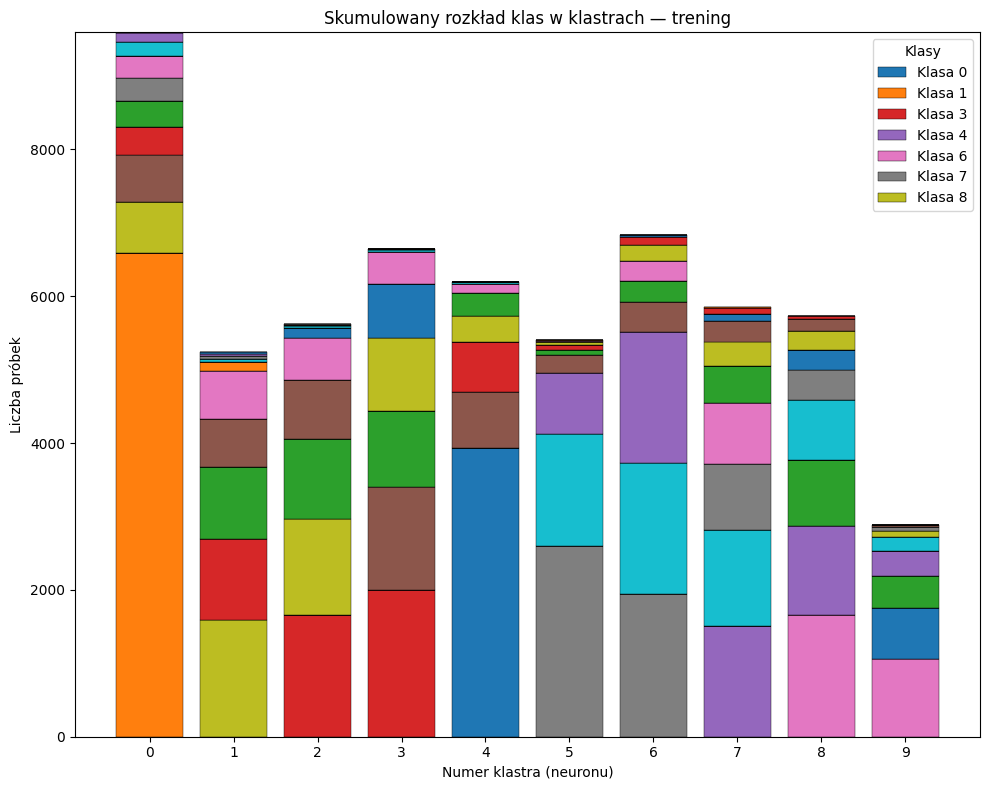

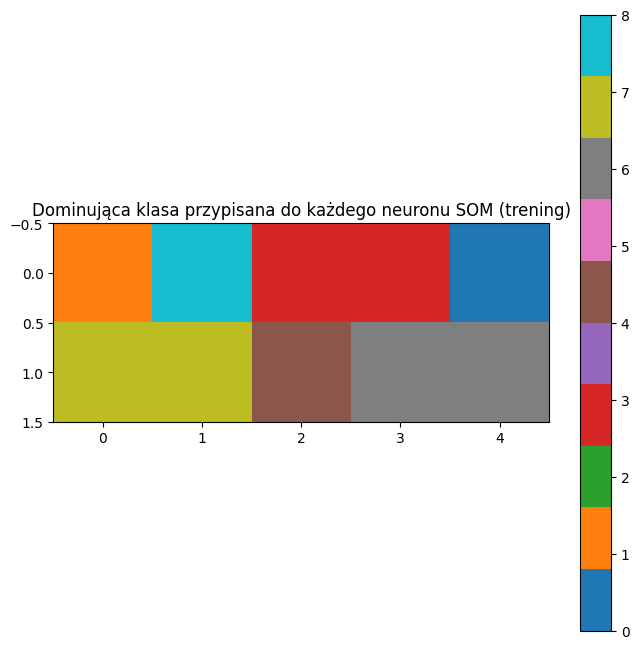

Accuracy na zbiorze testowym: 0.4144


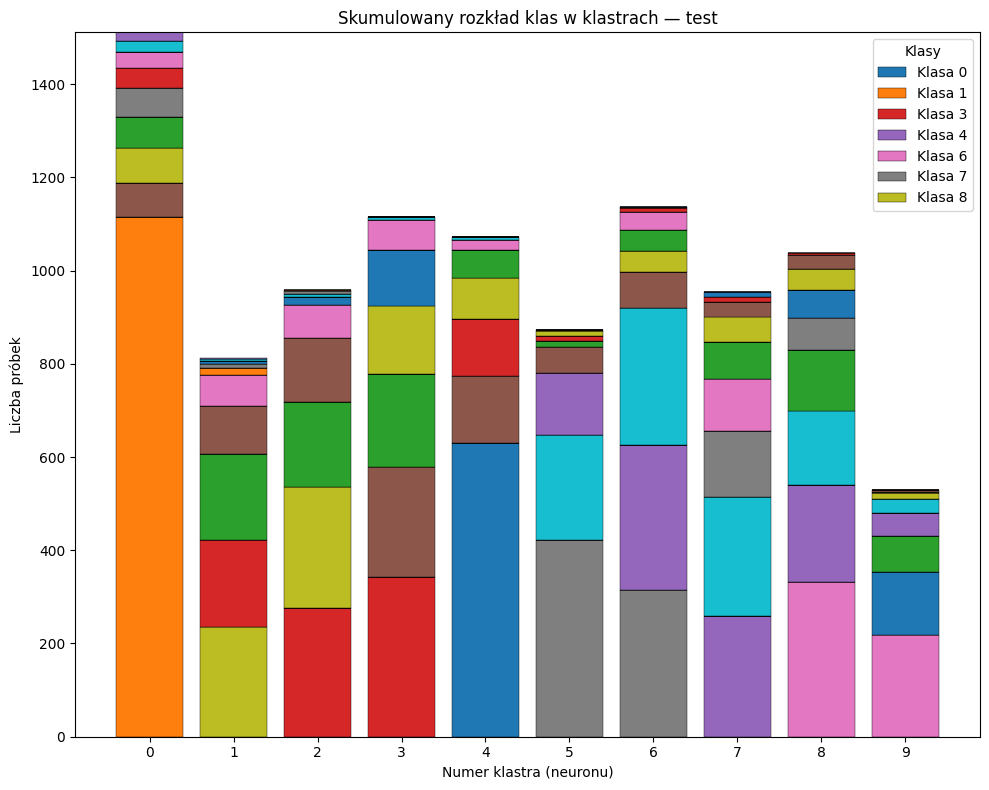

In [13]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=10000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.4670166666666667
Liczba klastrów: 21
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


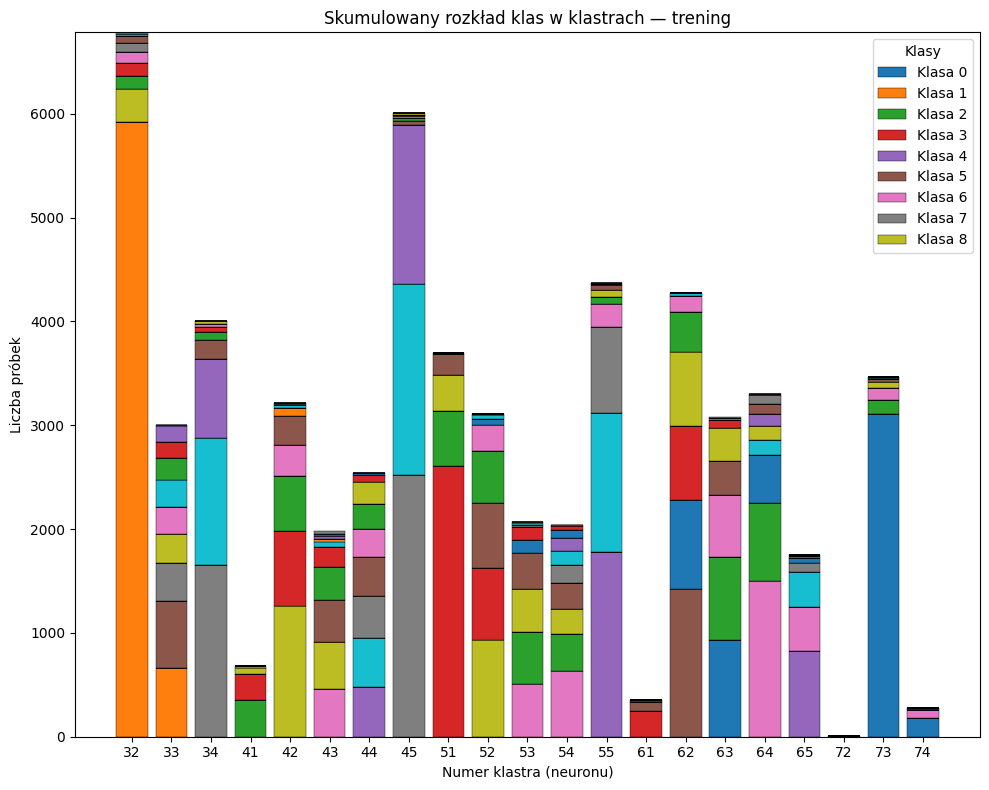

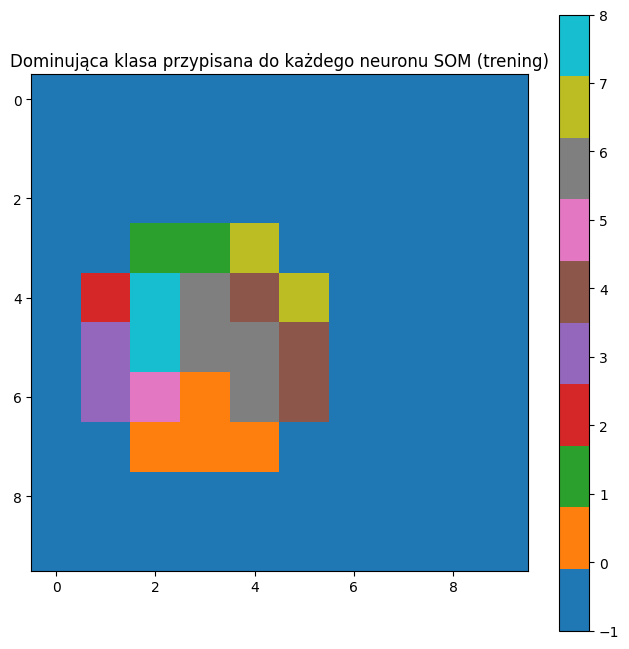

Accuracy na zbiorze testowym: 0.4698


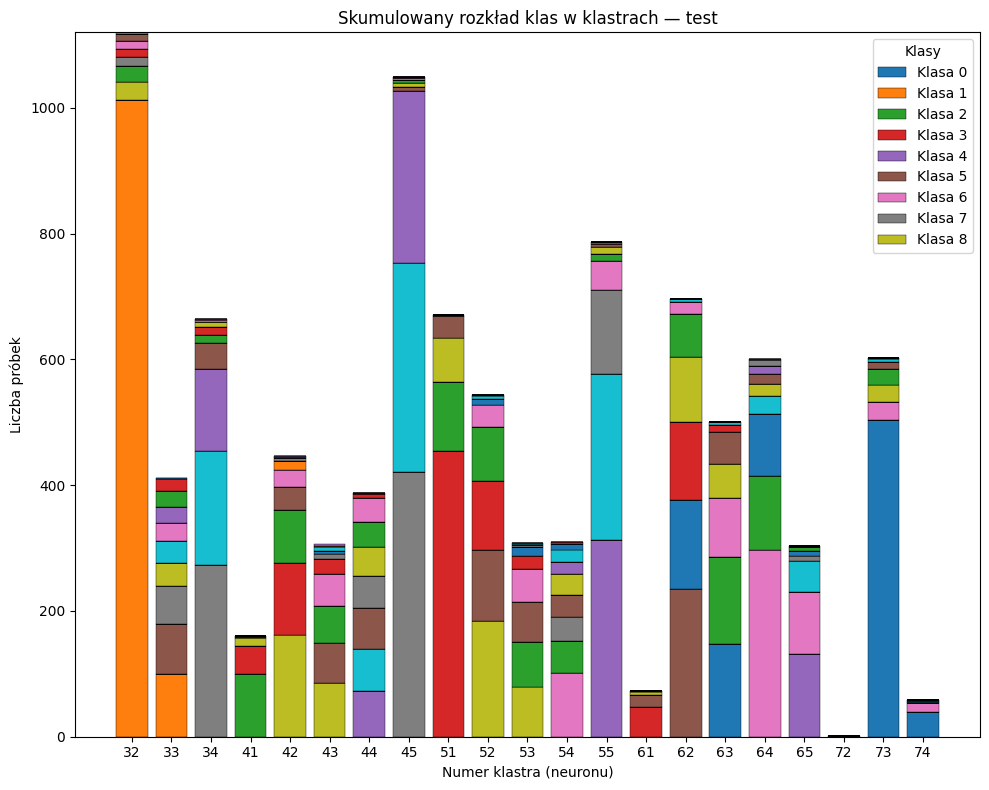

In [14]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=10, N=10, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=10000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.54345
Liczba klastrów: 42
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


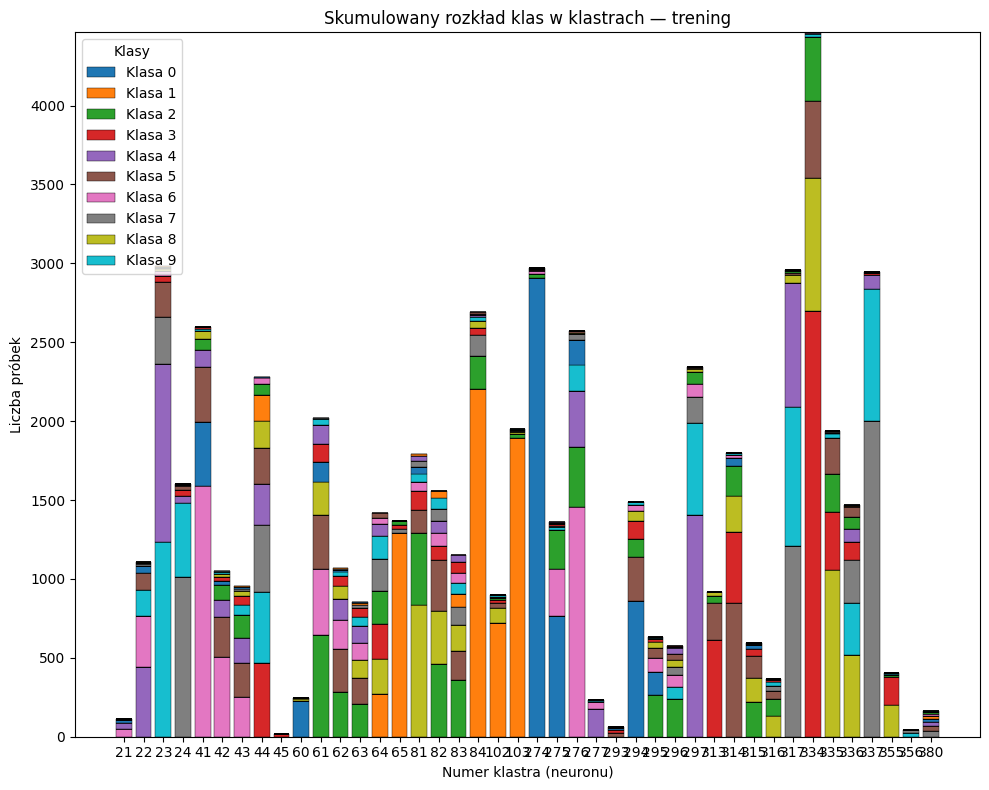

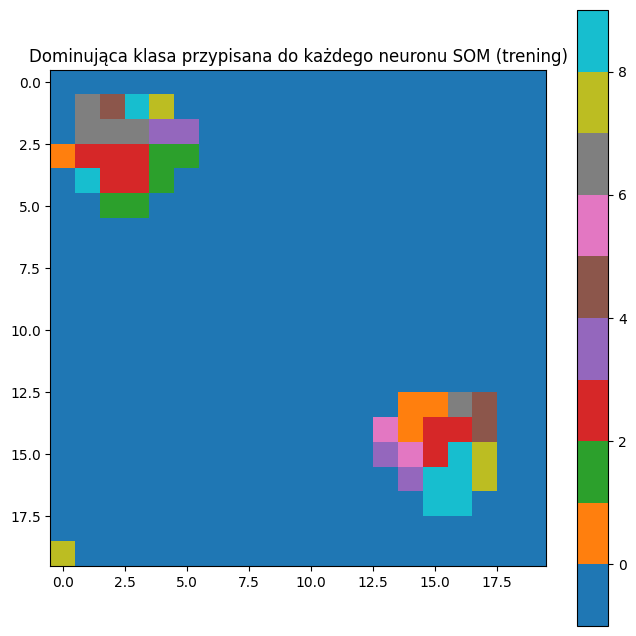

Accuracy na zbiorze testowym: 0.5487


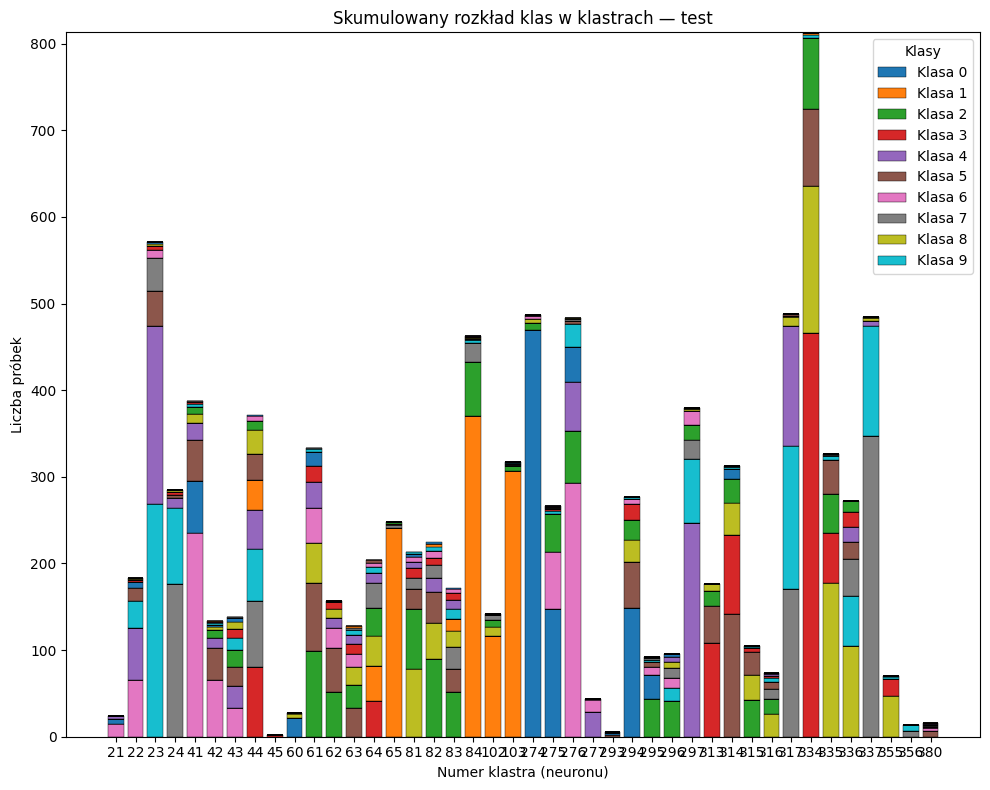

In [15]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=20, N=20, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=10000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| Minus 2-gauss      | matrix    | 3     | 2x5            | 0.4091         | 0.4144        | 10             |
| Minus 2-gauss      | matrix    | 3     | 10x10          | 0.4670         | 0.4698        | 21             |
| Minus 2-gauss      | matrix    | 3     | 20x20          | 0.5435         | 0.5487        | 42             |

### Minus 2-gauss, hex, 2x5,10x10,20x20

Dopasowana accuracy (trening): 0.39731666666666665
Liczba klastrów: 10
Liczba klas: 10
Liczba klastrów pokrywa się z liczbą klas.


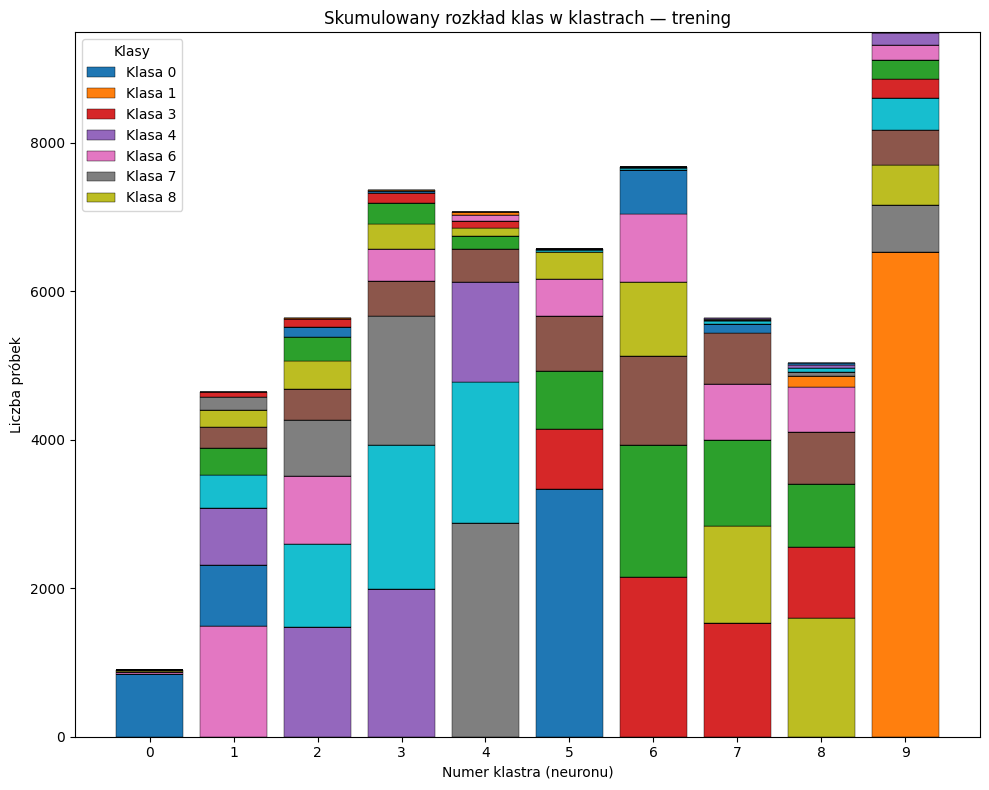

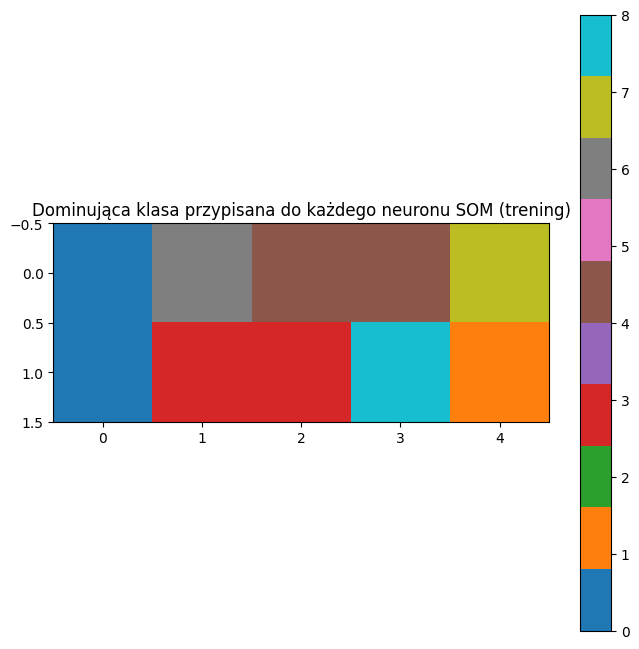

Accuracy na zbiorze testowym: 0.4035


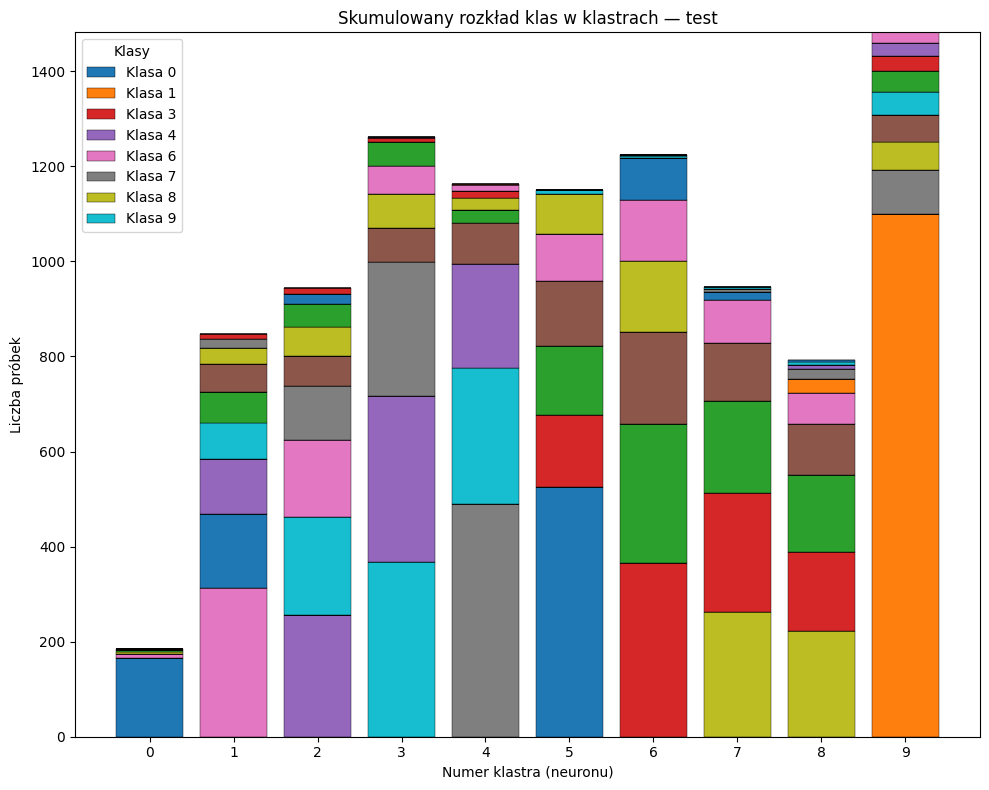

In [16]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=2, N=5, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=10000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.455
Liczba klastrów: 18
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


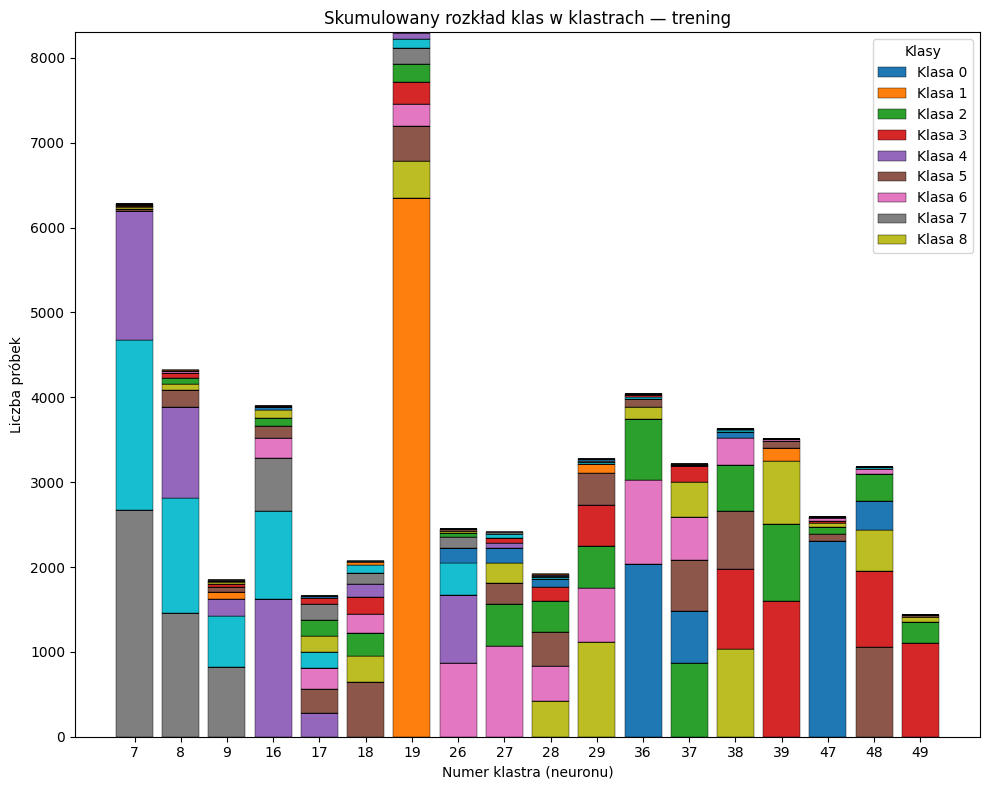

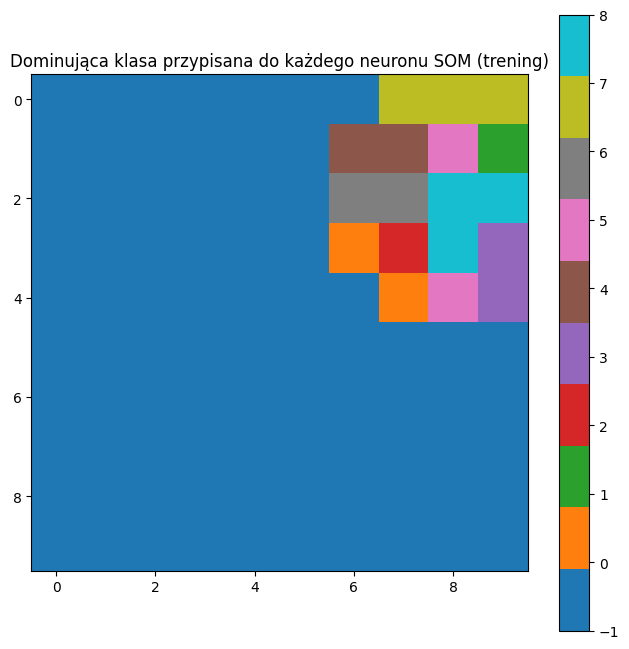

Accuracy na zbiorze testowym: 0.4641


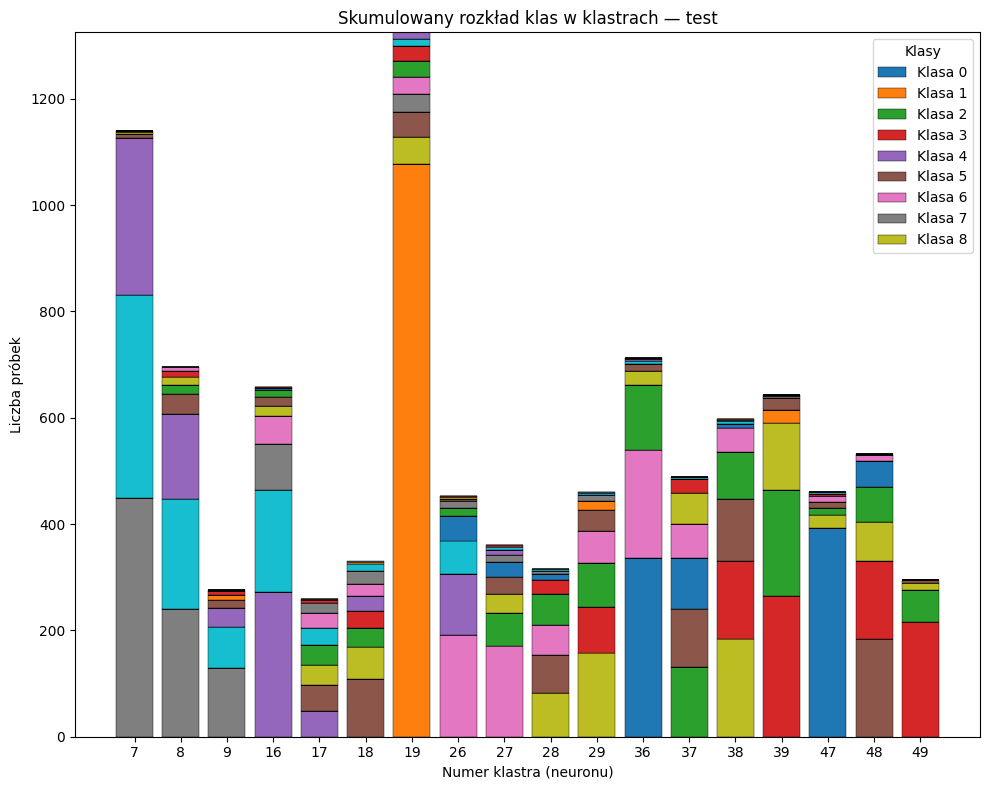

In [53]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=10, N=10, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=10000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.5216
Liczba klastrów: 35
Liczba klas: 10
Liczba klastrów nie pokrywa się z liczbą klas.


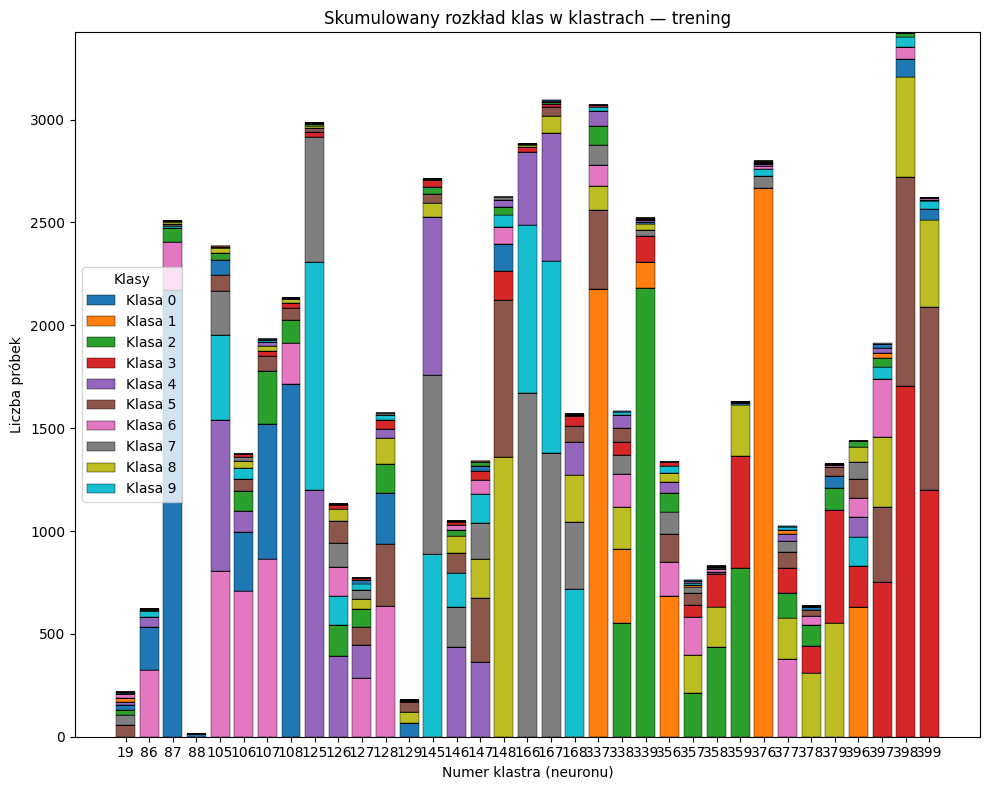

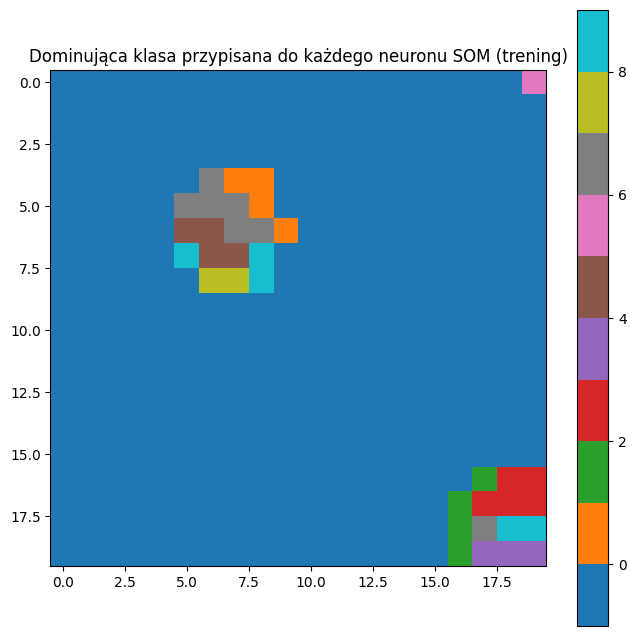

Accuracy na zbiorze testowym: 0.5327


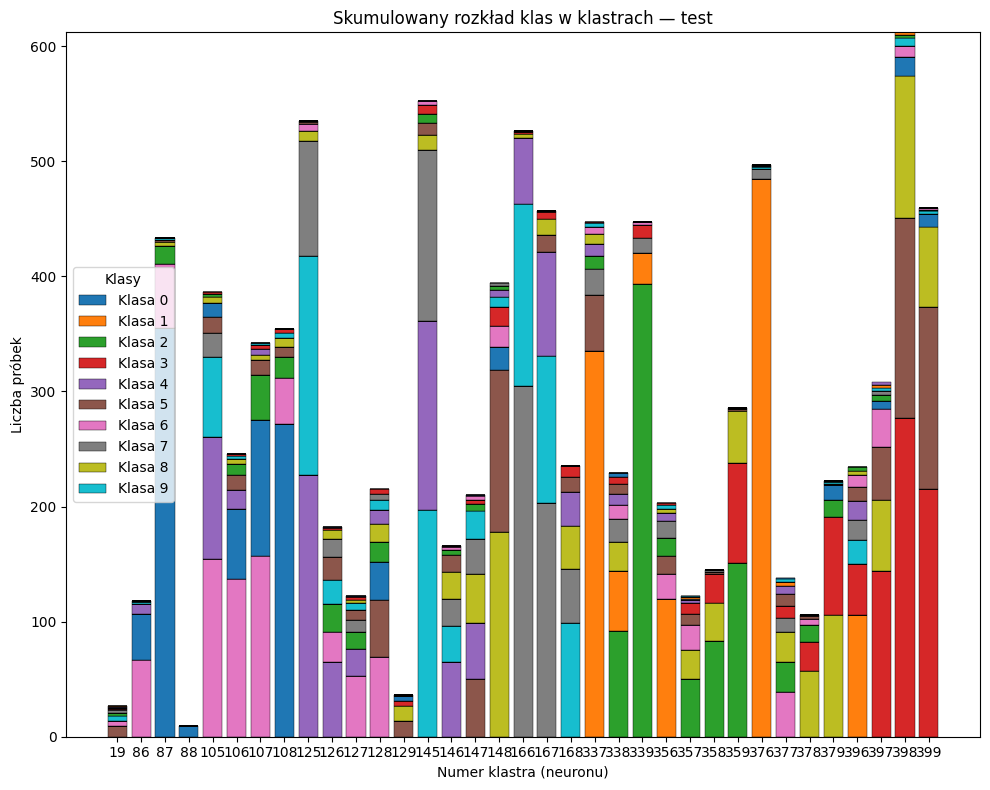

In [18]:
df = pd.read_csv("./data/mnist_train.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

df = pd.read_csv("./data/mnist_test.csv")
X_test = df.iloc[:, 1:].values
y_test = df.iloc[:, 0].values

network = KohonenNetwork(M=20, N=20, input_dim=784, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=10000, topology_type='hex')

show_results(network, X, y, X_test, y_test)


| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| Minus 2-gauss      | hex       | 3     | 2x5            | 0.3973         | 0.4035        | 10             |
| Minus 2-gauss      | hex       | 3     | 10x10          | 0.4550         | 0.4641        | 18             |
| Minus 2-gauss      | hex       | 3     | 20x20          | 0.5216         | 0.5327        | 35             |

## Zbiór UCI HAR

### znalezienie odpowiedniej sigmy

c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.1     accuracy =  0.1913764961915125


C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.1913764961915125
sigma =  1.09     accuracy =  0.3586779107725789
sigma =  1.585     accuracy =  0.35758977149075083
sigma =  2.08     accuracy =  0.4125408052230686
sigma =  2.575     accuracy =  0.4168933623503808
sigma =  3.07     accuracy =  0.3690152339499456
sigma =  3.565     accuracy =  0.36126224156692055
sigma =  4.06     accuracy =  0.3593579978237214
sigma =  4.555     accuracy =  0.35799782372143635
sigma =  5.05     accuracy =  0.35690968443960824
sigma =  5.545     accuracy =  0.35690968443960824
sigma =  6.039999999999999     accuracy =  0.35677366702937974
sigma =  6.534999999999999     accuracy =  0.35663764961915123
sigma =  7.029999999999999     accuracy =  0.35677366702937974
sigma =  7.5249999999999995     accuracy =  0.35677366702937974
sigma =  8.02     accuracy =  0.35663764961915123
sigma =  8.514999999999999     accuracy =  0.35663764961915123
sigma =  9.01     accuracy =  0.35663764961915123
sigma =  9.504999999999999     acc

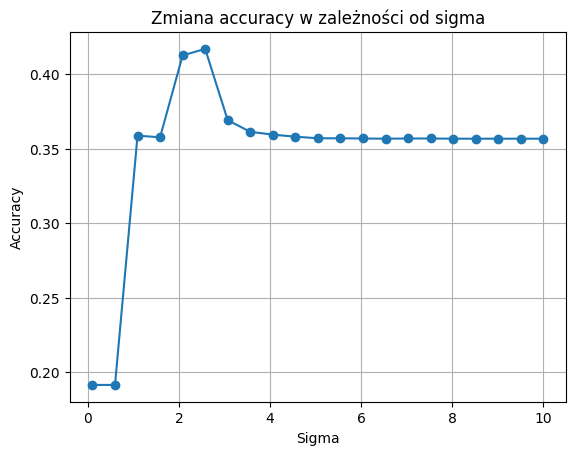

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='hex')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.1     accuracy =  0.1913764961915125


C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.1913764961915125
sigma =  1.09     accuracy =  0.352829162132753
sigma =  1.585     accuracy =  0.3590859630032644
sigma =  2.08     accuracy =  0.580114254624592
sigma =  2.575     accuracy =  0.5730413492927094
sigma =  3.07     accuracy =  0.4704842219804135
sigma =  3.565     accuracy =  0.6573721436343852
sigma =  4.06     accuracy =  0.5799782372143635
sigma =  4.555     accuracy =  0.5533188248095756
sigma =  5.05     accuracy =  0.6240478781284005
sigma =  5.545     accuracy =  0.5180903155603918
sigma =  6.039999999999999     accuracy =  0.43375952121871597
sigma =  6.534999999999999     accuracy =  0.4102285092491839
sigma =  7.029999999999999     accuracy =  0.40084330794341677
sigma =  7.5249999999999995     accuracy =  0.36547878128400435
sigma =  8.02     accuracy =  0.36180631120783463
sigma =  8.514999999999999     accuracy =  0.36126224156692055
sigma =  9.01     accuracy =  0.3604461371055495
sigma =  9.504999999999999     accuracy =  

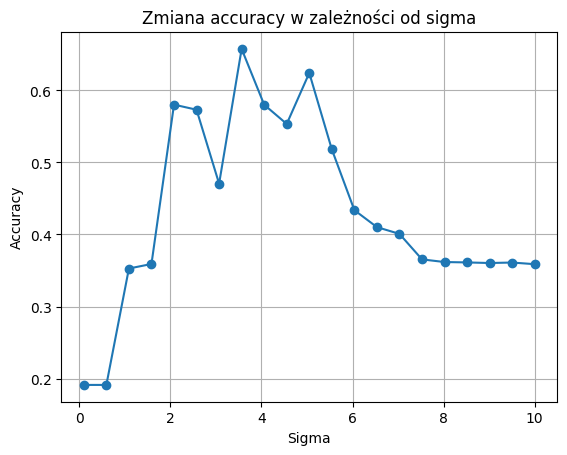

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='hex')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


sigma =  0.1     accuracy =  0.1913764961915125


c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.1913764961915125
sigma =  1.09     accuracy =  0.6462187159956474
sigma =  1.585     accuracy =  0.36180631120783463
sigma =  2.08     accuracy =  0.581474428726877
sigma =  2.575     accuracy =  0.6066376496191512
sigma =  3.07     accuracy =  0.5990206746463548
sigma =  3.565     accuracy =  0.6715179542981502
sigma =  4.06     accuracy =  0.5175462459194777
sigma =  4.555     accuracy =  0.5417573449401524
sigma =  5.05     accuracy =  0.6717899891186072
sigma =  5.545     accuracy =  0.6813112078346029
sigma =  6.039999999999999     accuracy =  0.5376768226332971
sigma =  6.534999999999999     accuracy =  0.7017138193688792
sigma =  7.029999999999999     accuracy =  0.7127312295973884
sigma =  7.5249999999999995     accuracy =  0.559575625680087
sigma =  8.02     accuracy =  0.6715179542981502
sigma =  8.514999999999999     accuracy =  0.638873775843308
sigma =  9.01     accuracy =  0.6576441784548422
sigma =  9.504999999999999     accuracy =  0.574

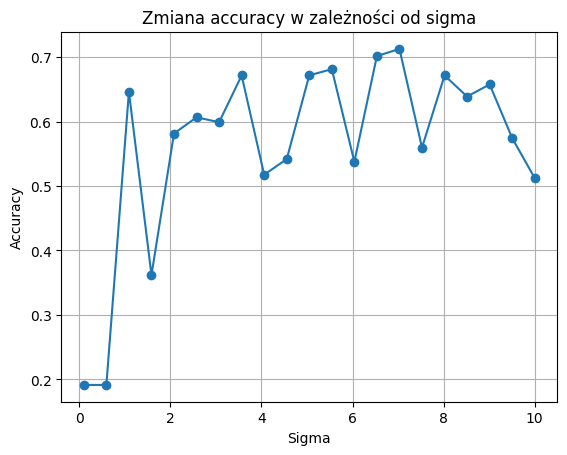

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=10, N=10, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='hex')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds]) 
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.1     accuracy =  0.1913764961915125


C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.1913764961915125
sigma =  1.09     accuracy =  0.35663764961915123
sigma =  1.585     accuracy =  0.3563656147986942
sigma =  2.08     accuracy =  0.5859630032644179
sigma =  2.575     accuracy =  0.36874319912948855
sigma =  3.07     accuracy =  0.3604461371055495
sigma =  3.565     accuracy =  0.3573177366702938
sigma =  4.06     accuracy =  0.35690968443960824
sigma =  4.555     accuracy =  0.35677366702937974
sigma =  5.05     accuracy =  0.35677366702937974
sigma =  5.545     accuracy =  0.35663764961915123
sigma =  6.039999999999999     accuracy =  0.35677366702937974
sigma =  6.534999999999999     accuracy =  0.35677366702937974
sigma =  7.029999999999999     accuracy =  0.3570457018498368
sigma =  7.5249999999999995     accuracy =  0.35677366702937974
sigma =  8.02     accuracy =  0.35663764961915123
sigma =  8.514999999999999     accuracy =  0.35663764961915123
sigma =  9.01     accuracy =  0.35663764961915123
sigma =  9.504999999999999     acc

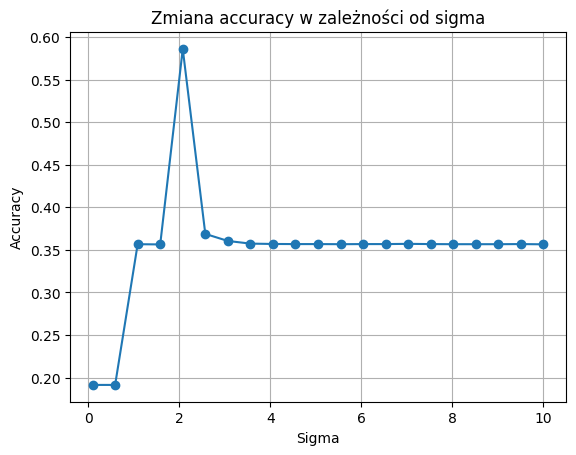

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='matrix')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.1     accuracy =  0.1913764961915125


C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.1913764961915125
sigma =  1.09     accuracy =  0.35663764961915123
sigma =  1.585     accuracy =  0.3563656147986942
sigma =  2.08     accuracy =  0.470620239390642
sigma =  2.575     accuracy =  0.4964635473340588
sigma =  3.07     accuracy =  0.6667573449401524
sigma =  3.565     accuracy =  0.6700217627856365
sigma =  4.06     accuracy =  0.5995647442872688
sigma =  4.555     accuracy =  0.5170021762785637
sigma =  5.05     accuracy =  0.4972796517954298
sigma =  5.545     accuracy =  0.4439608269858542
sigma =  6.039999999999999     accuracy =  0.39594668117519044
sigma =  6.534999999999999     accuracy =  0.37282372143634385
sigma =  7.029999999999999     accuracy =  0.3631664853101197
sigma =  7.5249999999999995     accuracy =  0.36194232861806314
sigma =  8.02     accuracy =  0.36112622415669204
sigma =  8.514999999999999     accuracy =  0.360310119695321
sigma =  9.01     accuracy =  0.3592219804134929
sigma =  9.504999999999999     accuracy =  

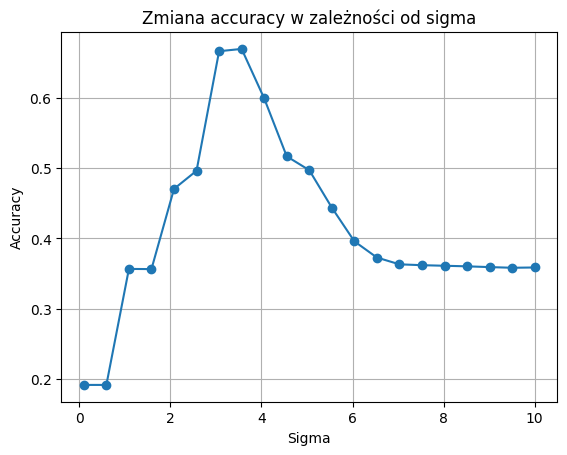

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='matrix')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


sigma =  0.1     accuracy =  0.1913764961915125


c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\Users\okroj\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\okroj\AppData\Local\Temp\ipykernel_9228\2384705976.py:60: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])


sigma =  0.595     accuracy =  0.1913764961915125
sigma =  1.09     accuracy =  0.3586779107725789
sigma =  1.585     accuracy =  0.35690968443960824
sigma =  2.08     accuracy =  0.48190968443960824
sigma =  2.575     accuracy =  0.42573449401523394
sigma =  3.07     accuracy =  0.6160228509249184
sigma =  3.565     accuracy =  0.5006800870511425
sigma =  4.06     accuracy =  0.5125136017410229
sigma =  4.555     accuracy =  0.6353373231773667
sigma =  5.05     accuracy =  0.5655603917301415
sigma =  5.545     accuracy =  0.5420293797606094
sigma =  6.039999999999999     accuracy =  0.5314200217627857
sigma =  6.534999999999999     accuracy =  0.6274483133841132
sigma =  7.029999999999999     accuracy =  0.7372143634385201
sigma =  7.5249999999999995     accuracy =  0.735038084874864
sigma =  8.02     accuracy =  0.5690968443960827
sigma =  8.514999999999999     accuracy =  0.7124591947769314
sigma =  9.01     accuracy =  0.54379760609358
sigma =  9.504999999999999     accuracy =  0.5

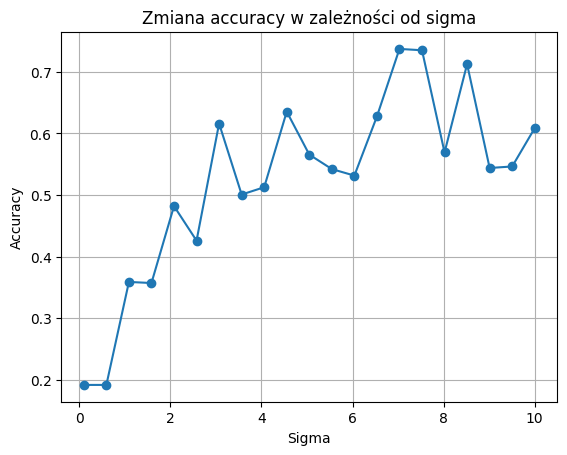

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:

    network = KohonenNetwork(M=10, N=10, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma=sigma)

   
    network.train(X, epochs=10000, topology_type='matrix')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()


sigma =  0.1     accuracy =  0.36207834602829164
sigma =  0.595     accuracy =  0.5892274211099021
sigma =  1.09     accuracy =  0.39567464635473343
sigma =  1.585     accuracy =  0.3599020674646355
sigma =  2.08     accuracy =  0.35799782372143635
sigma =  2.575     accuracy =  0.35677366702937974
sigma =  3.07     accuracy =  0.35663764961915123
sigma =  3.565     accuracy =  0.35663764961915123
sigma =  4.06     accuracy =  0.35663764961915123
sigma =  4.555     accuracy =  0.35663764961915123
sigma =  5.05     accuracy =  0.35677366702937974
sigma =  5.545     accuracy =  0.35663764961915123
sigma =  6.039999999999999     accuracy =  0.3565016322089227
sigma =  6.534999999999999     accuracy =  0.3565016322089227
sigma =  7.029999999999999     accuracy =  0.35663764961915123
sigma =  7.5249999999999995     accuracy =  0.3565016322089227
sigma =  8.02     accuracy =  0.3565016322089227
sigma =  8.514999999999999     accuracy =  0.3560935799782372
sigma =  9.01     accuracy =  0.3567

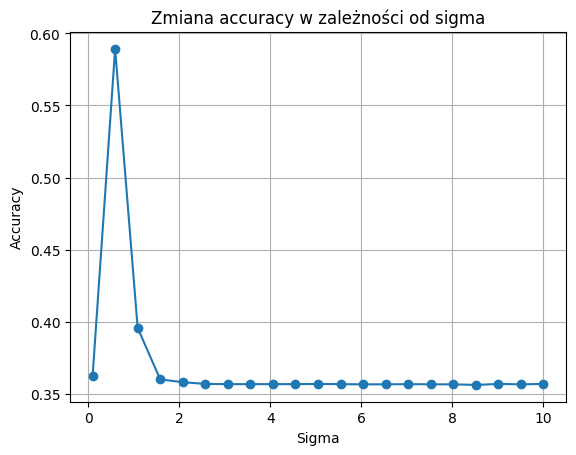

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='matrix')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y) 
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()

sigma =  0.1     accuracy =  0.36194232861806314
sigma =  0.595     accuracy =  0.778563656147987
sigma =  1.09     accuracy =  0.7199401523394995
sigma =  1.585     accuracy =  0.6866158868335147
sigma =  2.08     accuracy =  0.5232589771490751
sigma =  2.575     accuracy =  0.4027475516866159
sigma =  3.07     accuracy =  0.38071273122959737
sigma =  3.565     accuracy =  0.3627584330794342
sigma =  4.06     accuracy =  0.36126224156692055
sigma =  4.555     accuracy =  0.3604461371055495
sigma =  5.05     accuracy =  0.3588139281828074
sigma =  5.545     accuracy =  0.3590859630032644
sigma =  6.039999999999999     accuracy =  0.3574537540805223
sigma =  6.534999999999999     accuracy =  0.35690968443960824
sigma =  7.029999999999999     accuracy =  0.3571817192600653
sigma =  7.5249999999999995     accuracy =  0.35677366702937974
sigma =  8.02     accuracy =  0.3571817192600653
sigma =  8.514999999999999     accuracy =  0.3571817192600653
sigma =  9.01     accuracy =  0.35690968443

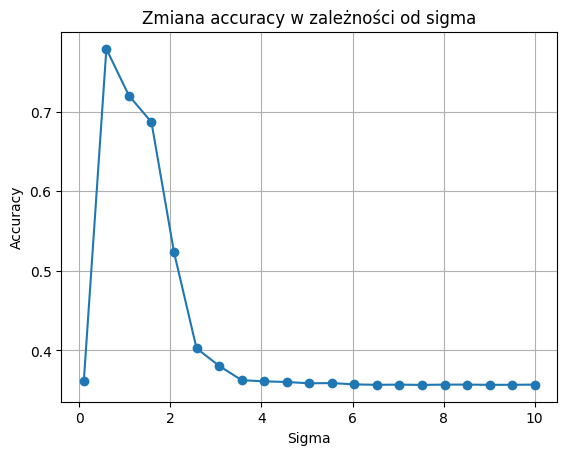

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = [] 

for sigma in sigmas:
    network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='matrix')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy) 
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()

sigma =  0.1     accuracy =  0.3570457018498368
sigma =  0.595     accuracy =  0.5846028291621328
sigma =  1.09     accuracy =  0.39594668117519044
sigma =  1.585     accuracy =  0.3596300326441785
sigma =  2.08     accuracy =  0.3590859630032644
sigma =  2.575     accuracy =  0.3571817192600653
sigma =  3.07     accuracy =  0.35690968443960824
sigma =  3.565     accuracy =  0.35677366702937974
sigma =  4.06     accuracy =  0.35663764961915123
sigma =  4.555     accuracy =  0.35663764961915123
sigma =  5.05     accuracy =  0.35663764961915123
sigma =  5.545     accuracy =  0.35677366702937974
sigma =  6.039999999999999     accuracy =  0.35663764961915123
sigma =  6.534999999999999     accuracy =  0.35677366702937974
sigma =  7.029999999999999     accuracy =  0.35663764961915123
sigma =  7.5249999999999995     accuracy =  0.35663764961915123
sigma =  8.02     accuracy =  0.3565016322089227
sigma =  8.514999999999999     accuracy =  0.35677366702937974
sigma =  9.01     accuracy =  0.356

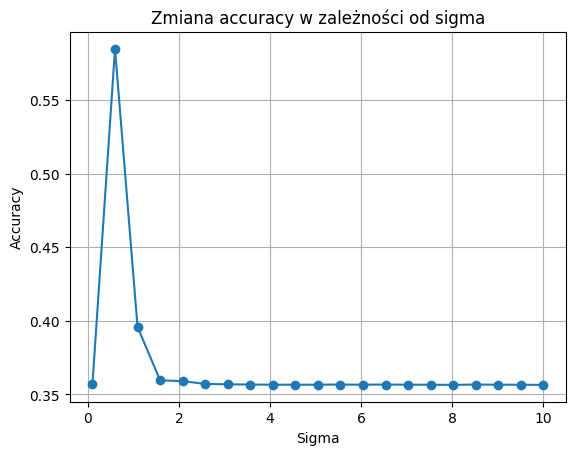

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='hex')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])  
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy)  
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()

sigma =  0.1     accuracy =  0.4099564744287269
sigma =  0.595     accuracy =  0.7780195865070729
sigma =  1.09     accuracy =  0.7599292709466812
sigma =  1.585     accuracy =  0.6969532100108814
sigma =  2.08     accuracy =  0.6481229597388466
sigma =  2.575     accuracy =  0.5750816104461371
sigma =  3.07     accuracy =  0.5553590859630033
sigma =  3.565     accuracy =  0.3736398258977149
sigma =  4.06     accuracy =  0.36547878128400435
sigma =  4.555     accuracy =  0.36153427638737756
sigma =  5.05     accuracy =  0.360310119695321
sigma =  5.545     accuracy =  0.35840587595212187
sigma =  6.039999999999999     accuracy =  0.35813384113166485
sigma =  6.534999999999999     accuracy =  0.35786180631120784
sigma =  7.029999999999999     accuracy =  0.35813384113166485
sigma =  7.5249999999999995     accuracy =  0.3570457018498368
sigma =  8.02     accuracy =  0.3570457018498368
sigma =  8.514999999999999     accuracy =  0.3571817192600653
sigma =  9.01     accuracy =  0.3569096844

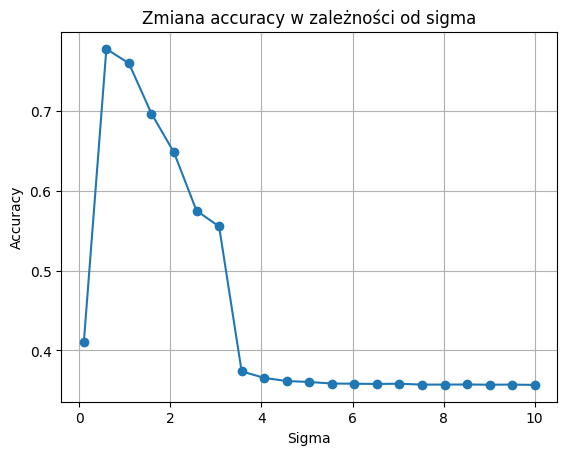

In [ ]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

sigmas = np.linspace(0.1, 10, 21)
accuracies = []  

for sigma in sigmas:
    network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="gaussian", sigma=sigma)

    network.train(X, epochs=10000, topology_type='hex')

    preds = network.get_cluster_assignments(X)
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {cluster: Counter(labels).most_common(1)[0][0]
               for cluster, labels in cluster_to_labels.items()}

    mapped_preds = np.array([mapping.get(p, -1) for p in preds]) 
    accuracy = np.mean(mapped_preds == y)  
    accuracies.append(accuracy) 
    print("sigma = ", sigma, "    accuracy = ", accuracy)

plt.plot(sigmas, accuracies, marker='o', linestyle='-')
plt.xlabel("Sigma")
plt.ylabel("Accuracy")
plt.title("Zmiana accuracy w zależności od sigma")
plt.grid()
plt.show()

### gauss, matrix, 2x3,5x5,10x10

Dopasowana accuracy (trening): 0.5791621327529923
Liczba klastrów: 6
Liczba klas: 6
Liczba klastrów pokrywa się z liczbą klas.


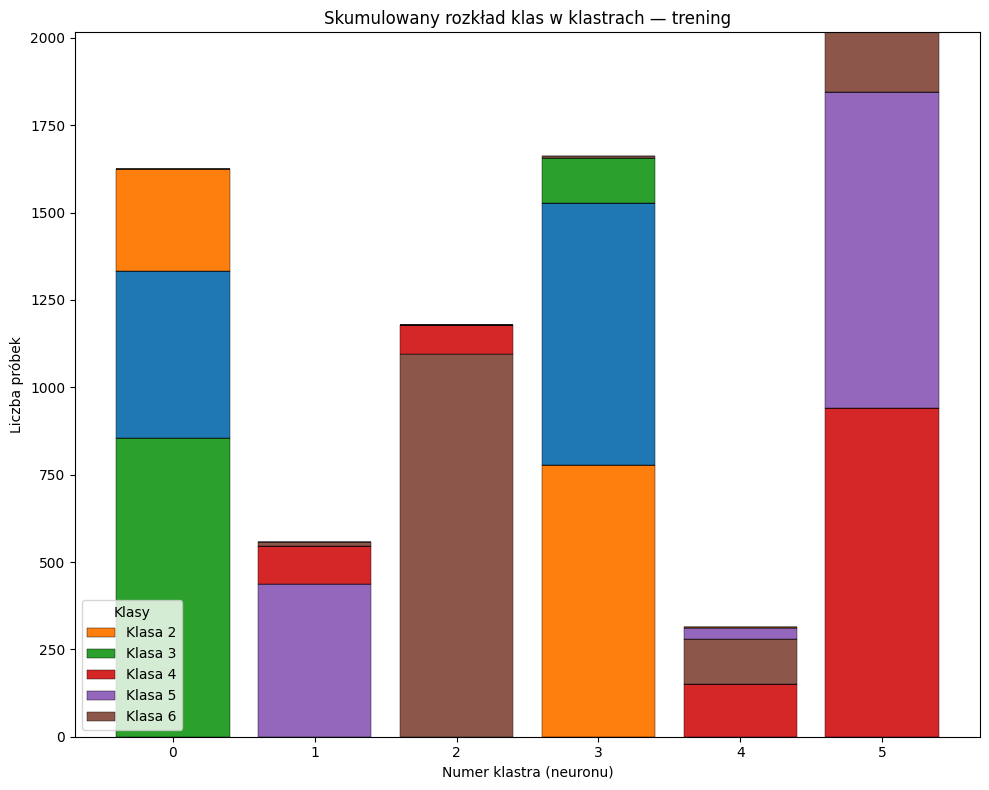

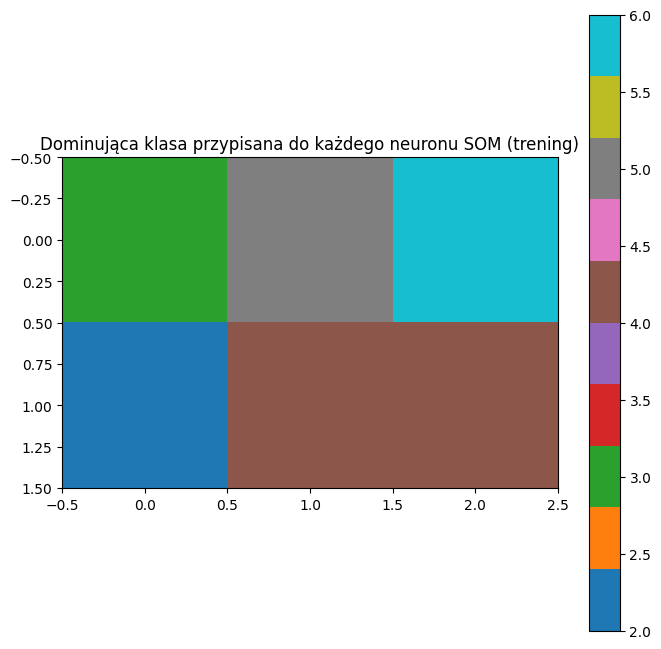

Accuracy na zbiorze testowym: 0.5907702748557856


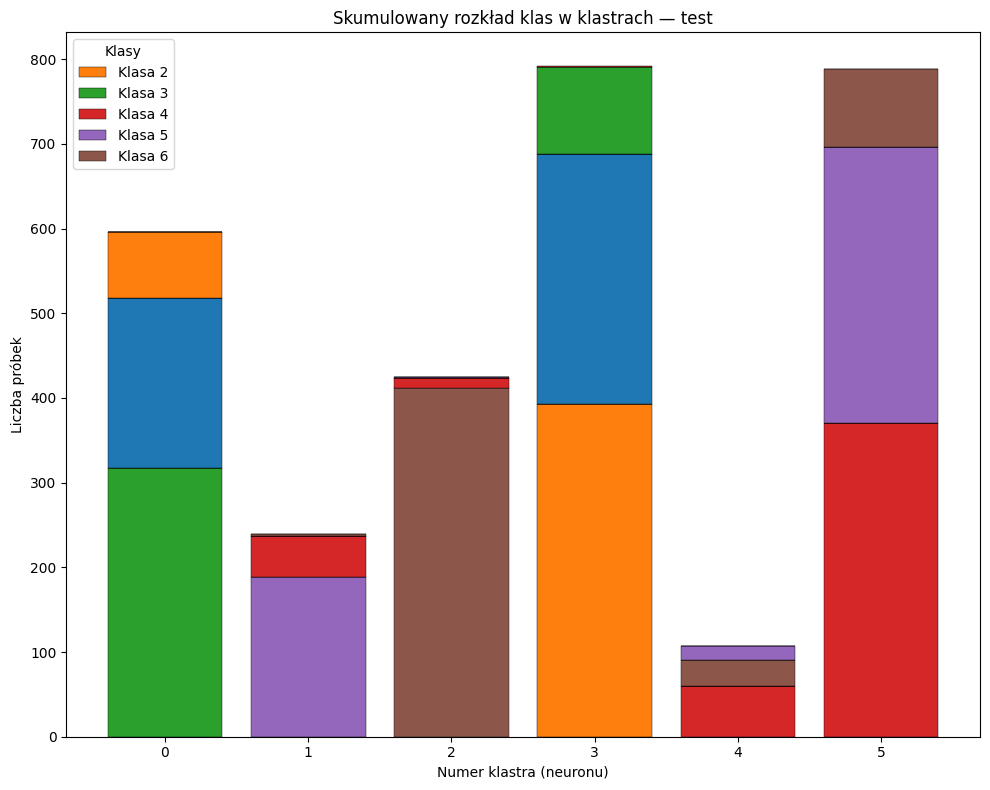

In [47]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="gaussian", sigma = 0.5)

network.train(X, epochs=1000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.7128672470076169
Liczba klastrów: 25
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


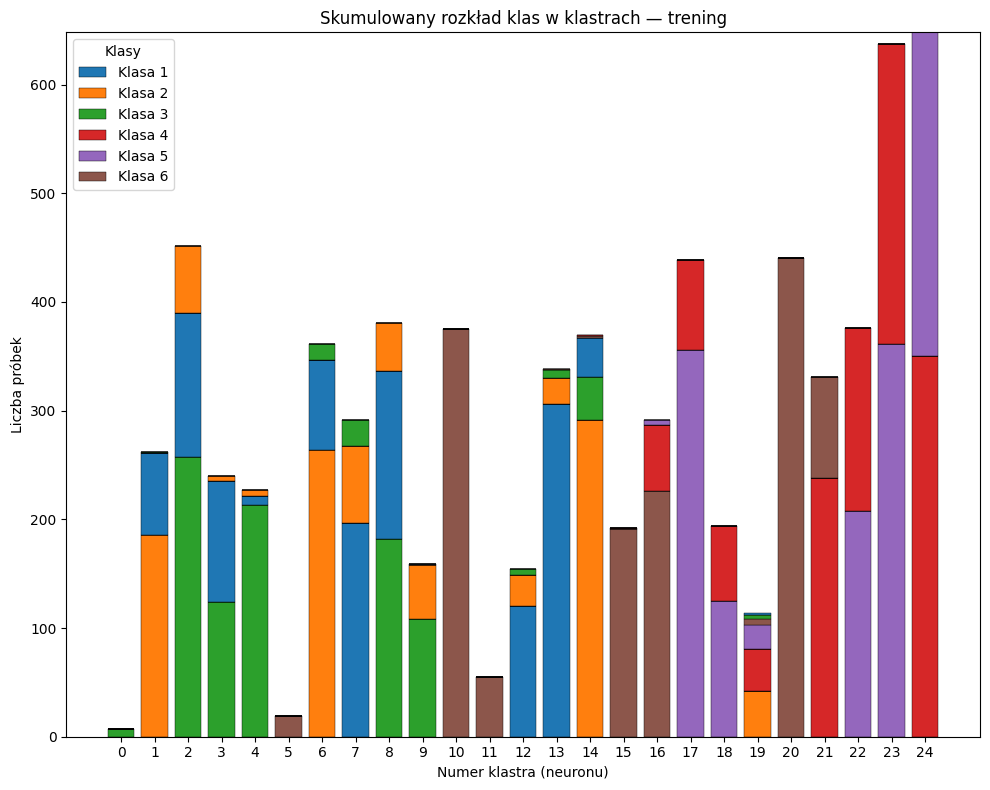

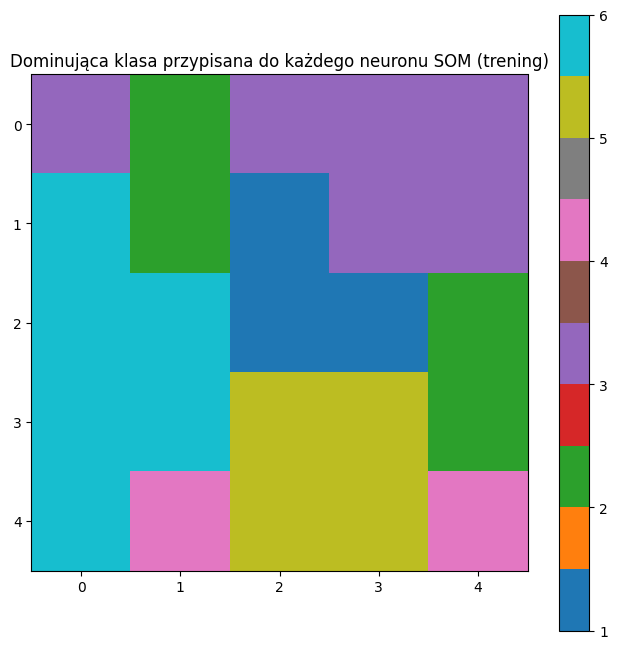

Accuracy na zbiorze testowym: 0.7271801832371904


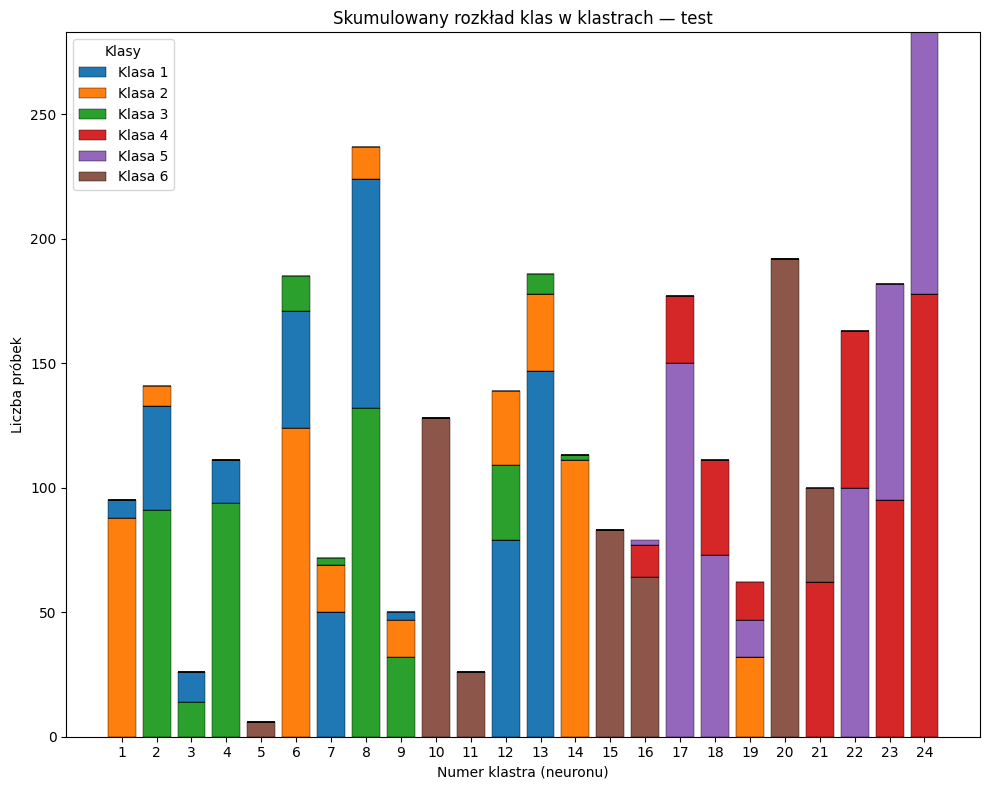

In [48]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="gaussian", sigma = 0.5)

network.train(X, epochs=1000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.7232045701849836
Liczba klastrów: 27
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


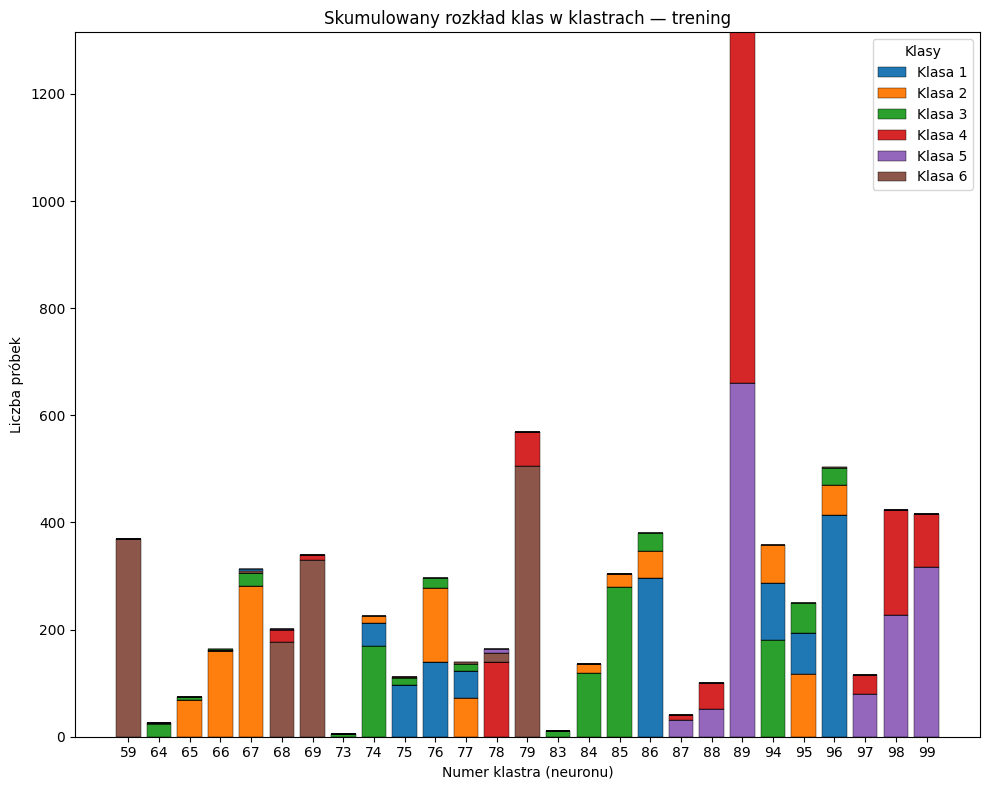

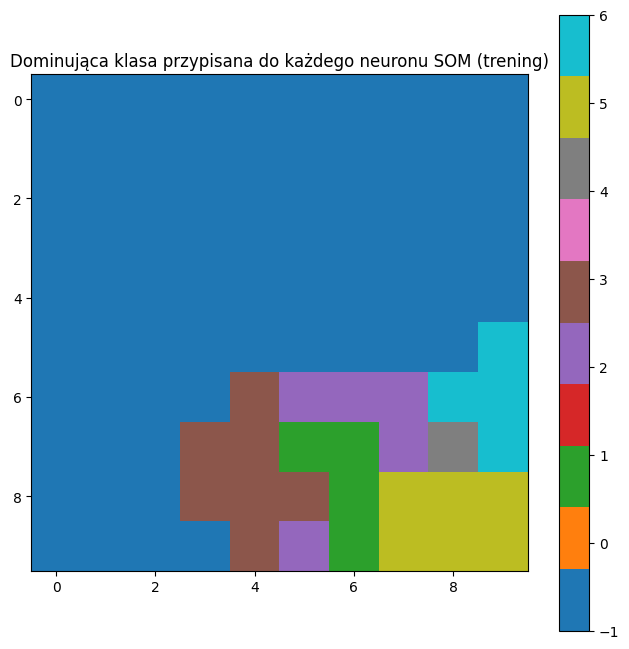

Accuracy na zbiorze testowym: 0.6932473702069901


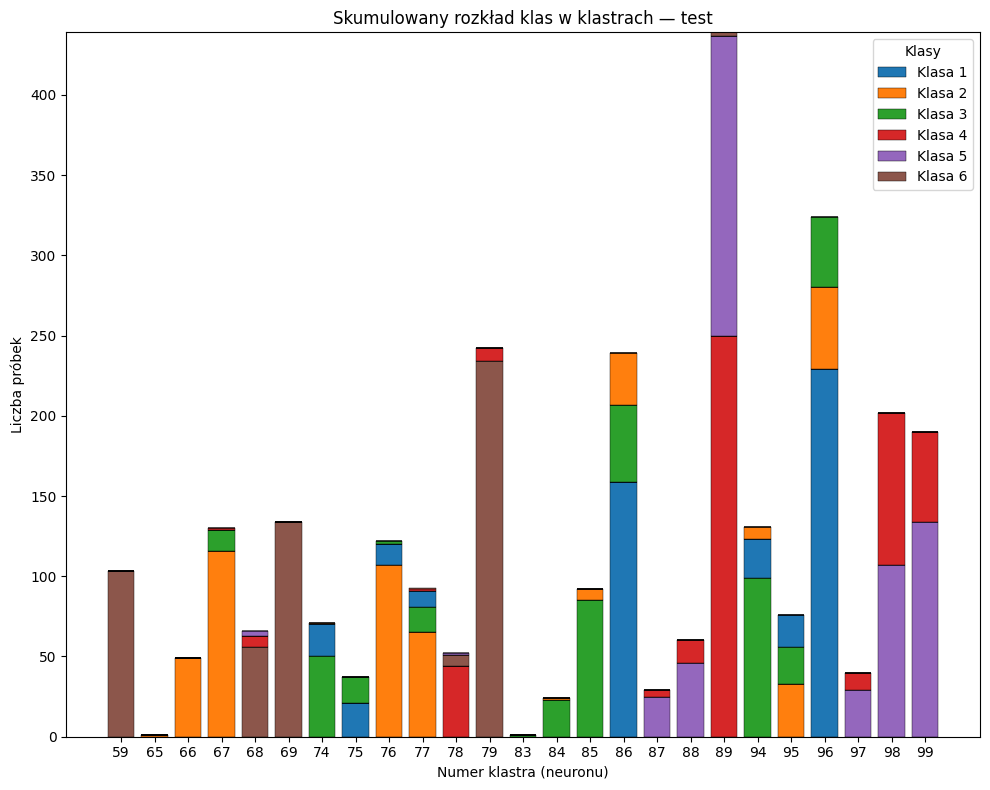

In [49]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=10, N=10, input_dim=561, neighborhood_function="gaussian", sigma = 0.5)

network.train(X, epochs=1000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| gauss              | matrix    | 0.5   | 2x3            | 0.5792         | 0.5908        | 6              |
| gauss              | matrix    | 0.5   | 5x5            | 0.7129         | 0.7272        | 25             |
| gauss              | matrix    | 0.5   | 10x10          | 0.7232         | 0.6932        | 27             |

### gaussian, hex, 2x3,5x5,10x10

Dopasowana accuracy (trening): 0.5775299238302503
Liczba klastrów: 6
Liczba klas: 6
Liczba klastrów pokrywa się z liczbą klas.


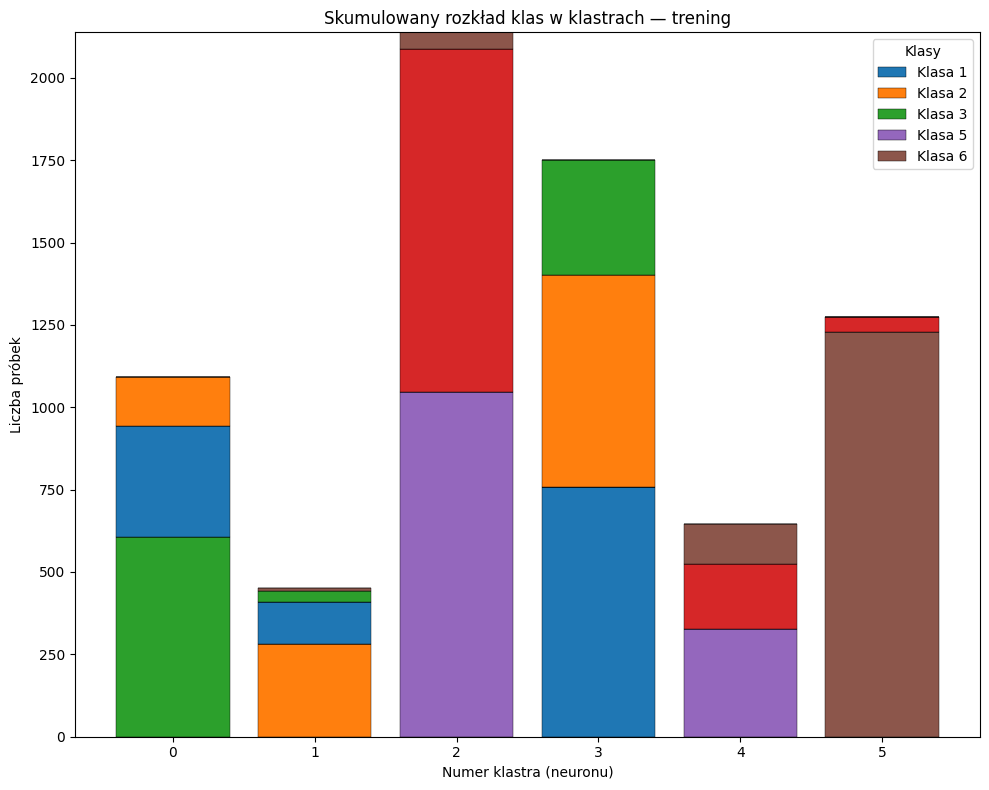

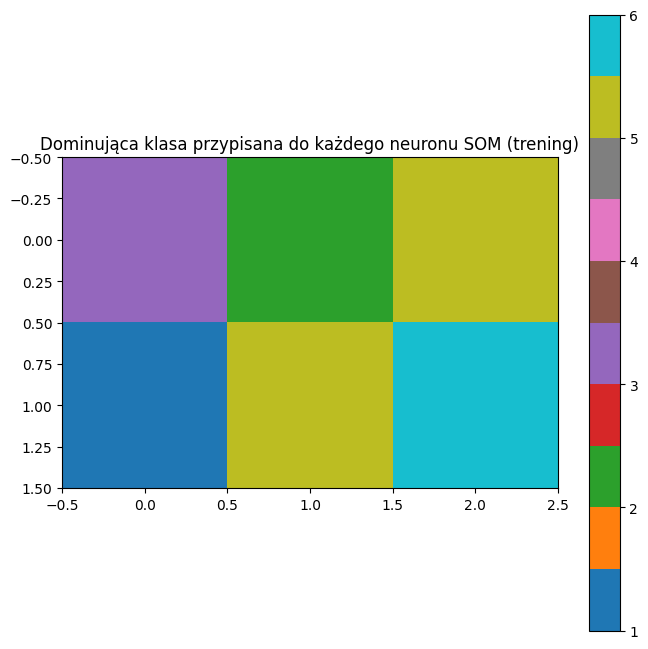

Accuracy na zbiorze testowym: 0.5626060400407193


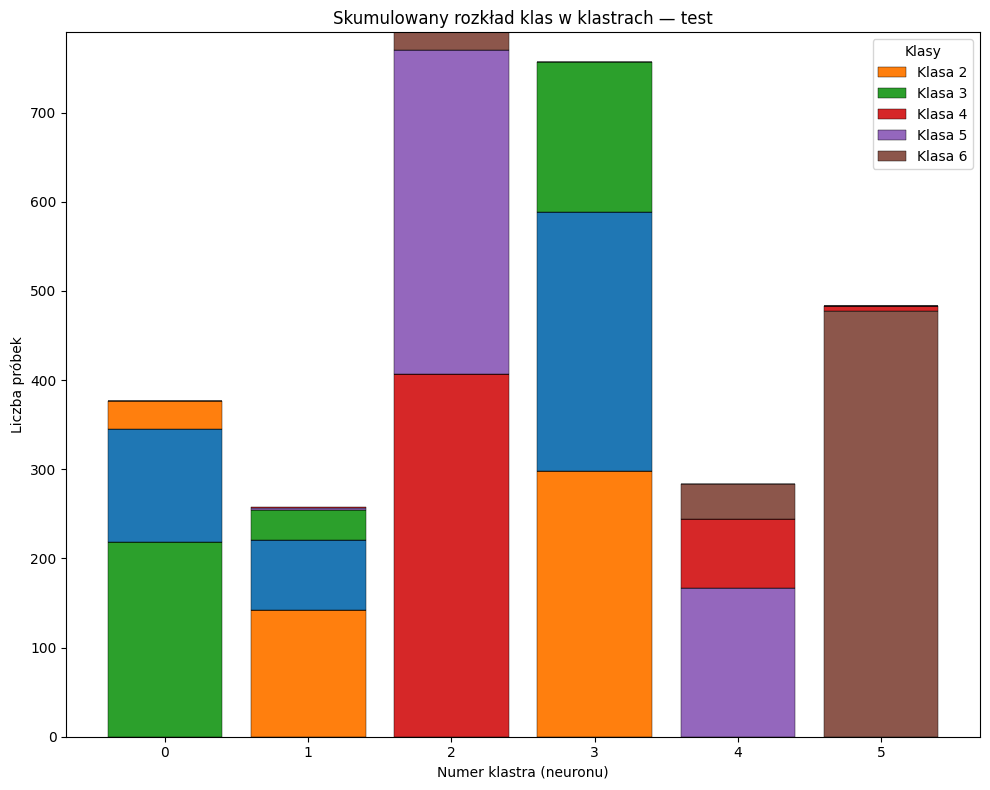

In [50]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="gaussian", sigma = 0.5)

network.train(X, epochs=1000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.7557127312295974
Liczba klastrów: 25
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


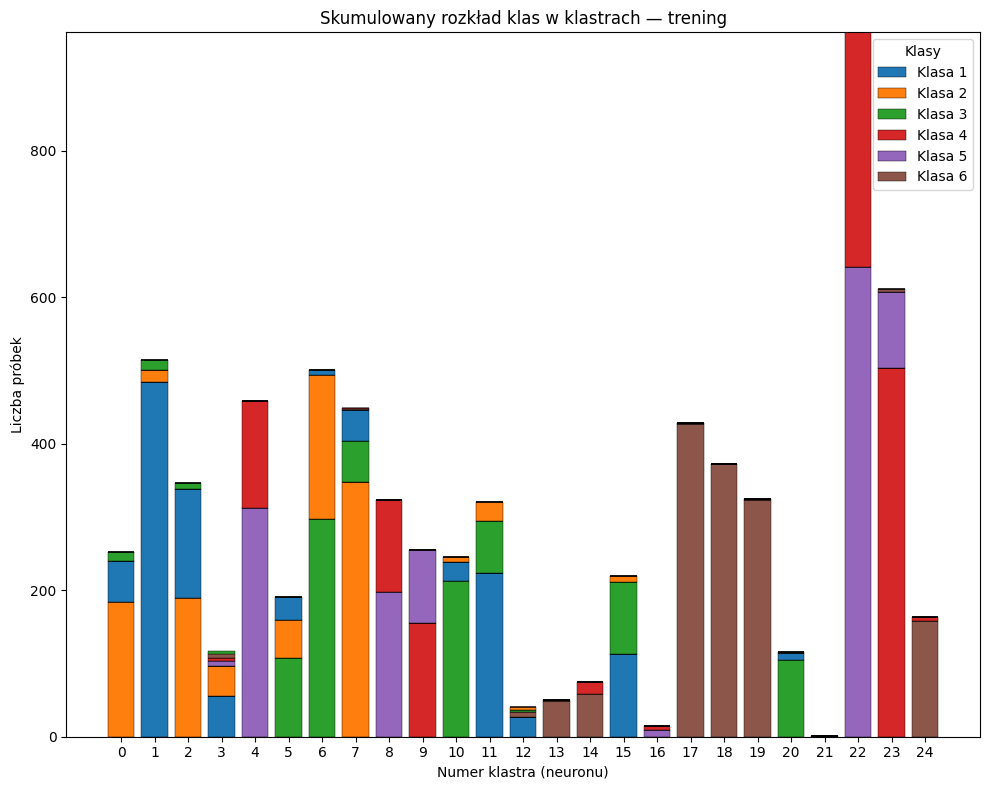

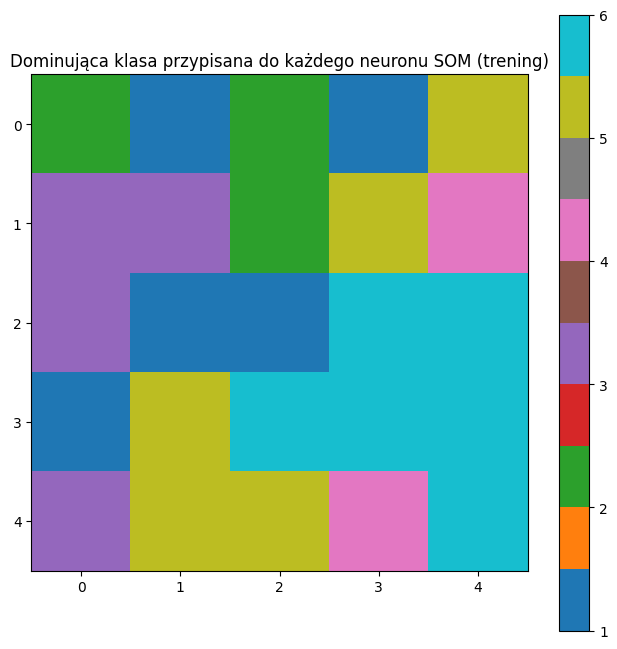

Accuracy na zbiorze testowym: 0.7356633864947404


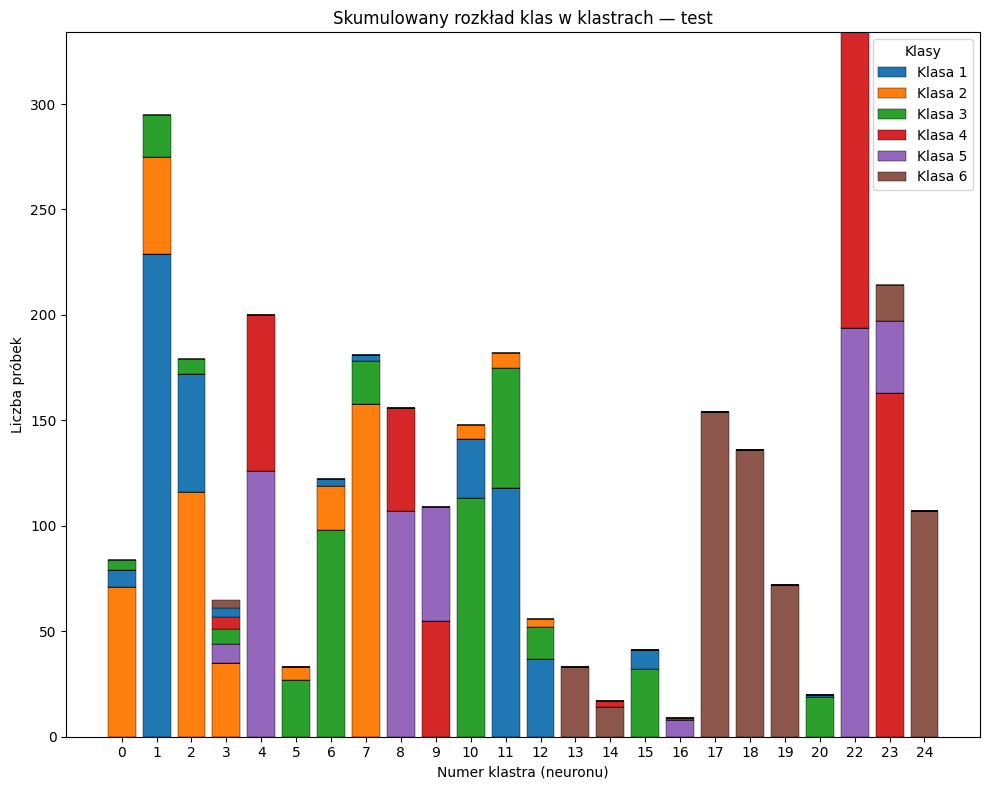

In [51]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="gaussian", sigma = 0.5)

network.train(X, epochs=1000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.7985582154515778
Liczba klastrów: 44
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


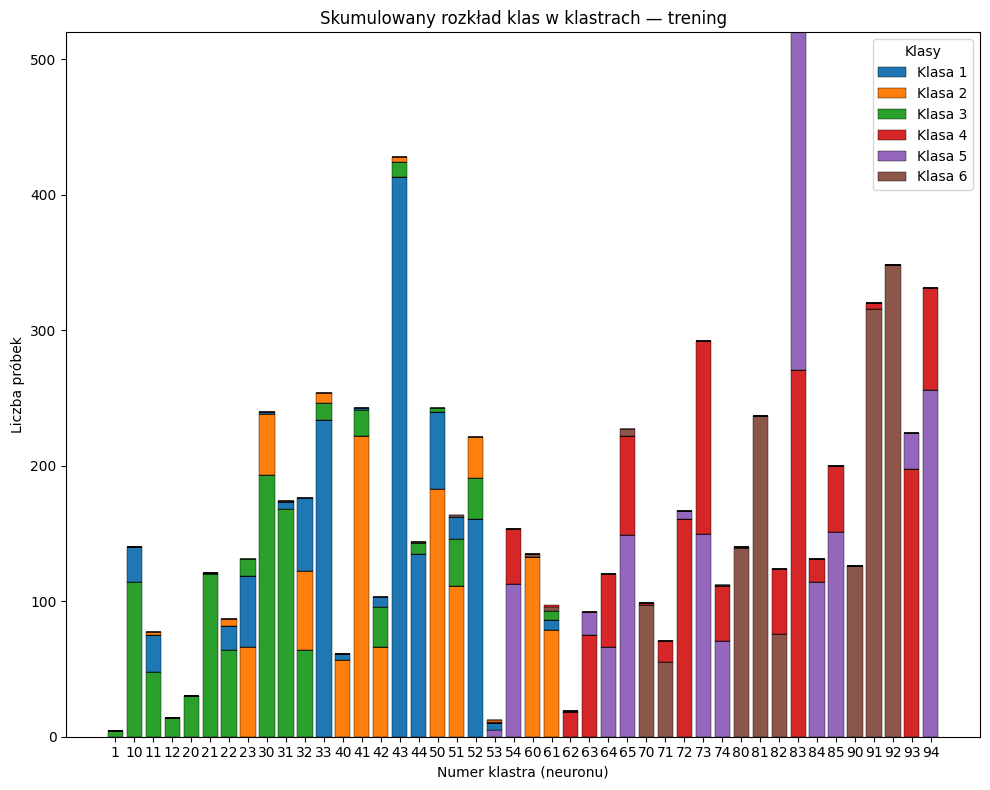

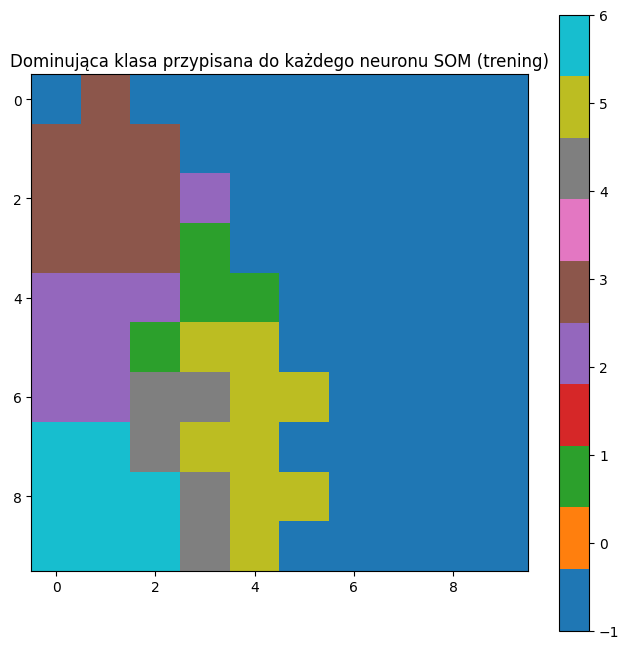

Accuracy na zbiorze testowym: 0.7879199185612488


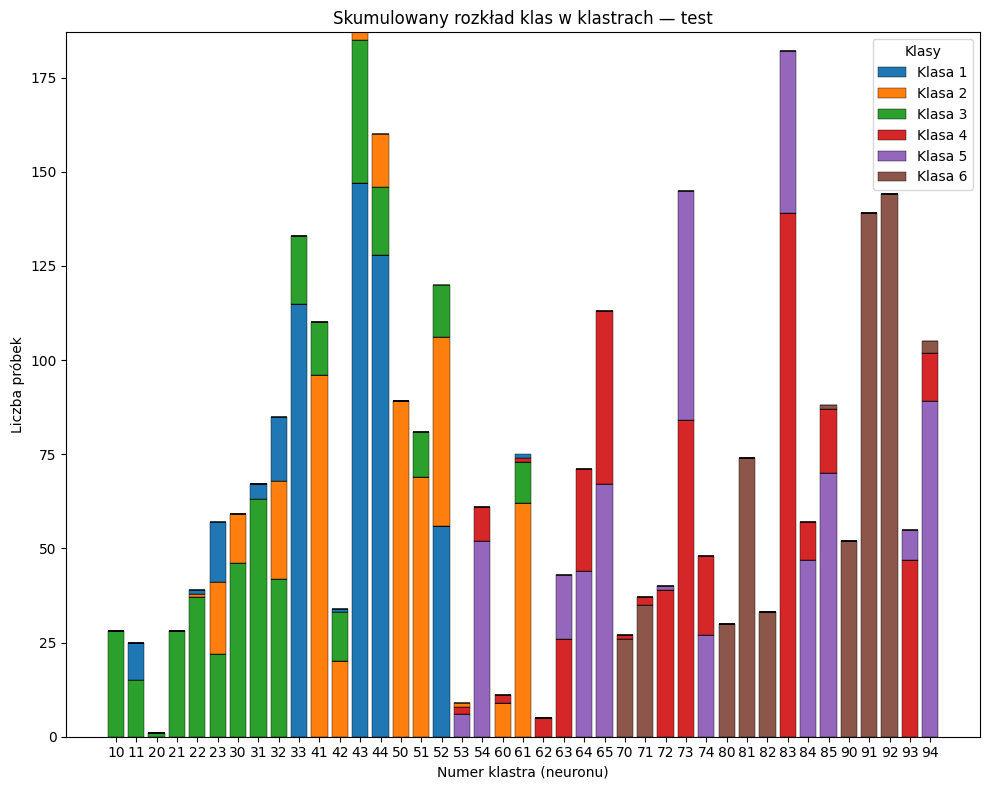

In [52]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=10, N=10, input_dim=561, neighborhood_function="gaussian", sigma = 0.5)

network.train(X, epochs=1000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| gauss              | hex       | 0.5   | 2x3            | 0.5775         | 0.5626        | 6              |
| gauss              | hex       | 0.5   | 5x5            | 0.7557         | 0.7357        | 25             |
| gauss              | hex       | 0.5   | 10x10          | 0.7986         | 0.7879        | 44             |

### second_derivative_gaussian, matrix, 2x3,5x5,10x10,20x20

Dopasowana accuracy (trening): 0.3735038084874864
Liczba klastrów: 6
Liczba klas: 6
Liczba klastrów pokrywa się z liczbą klas.


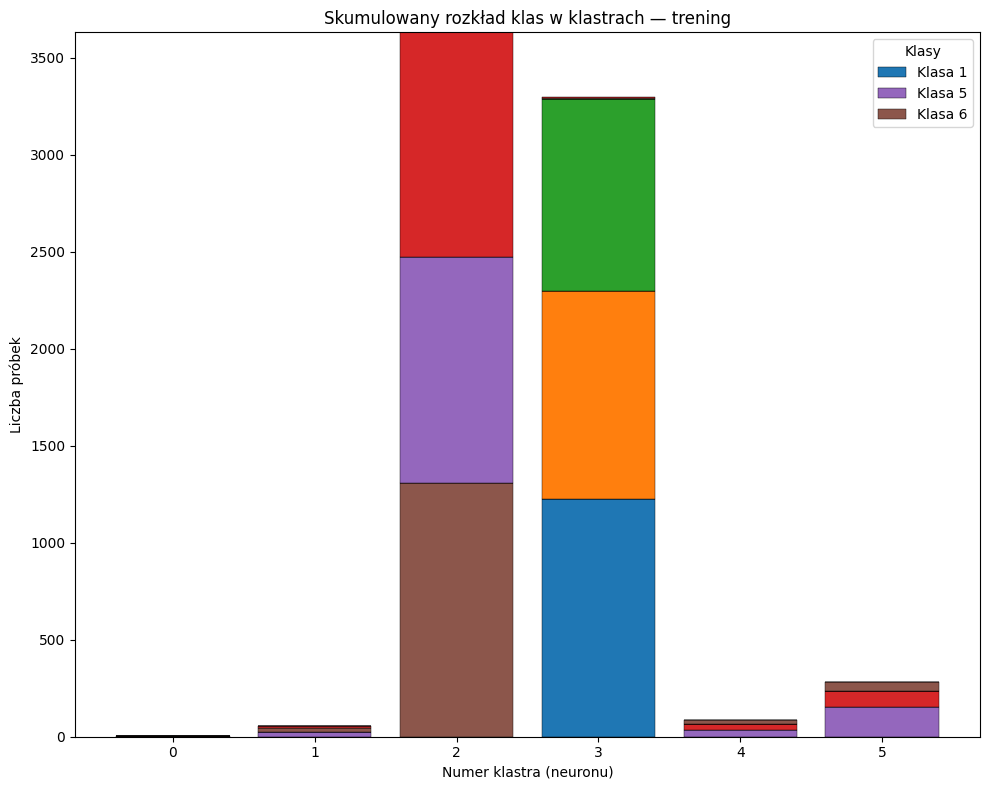

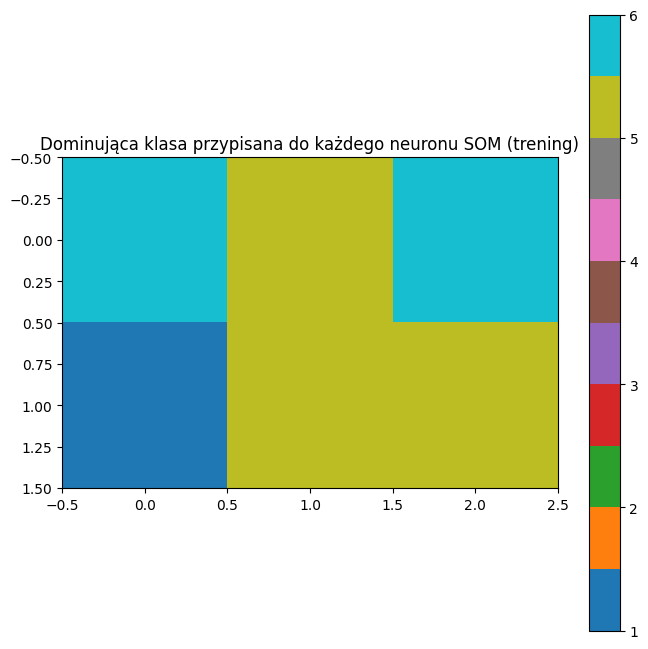

Accuracy na zbiorze testowym: 0.37665422463522225


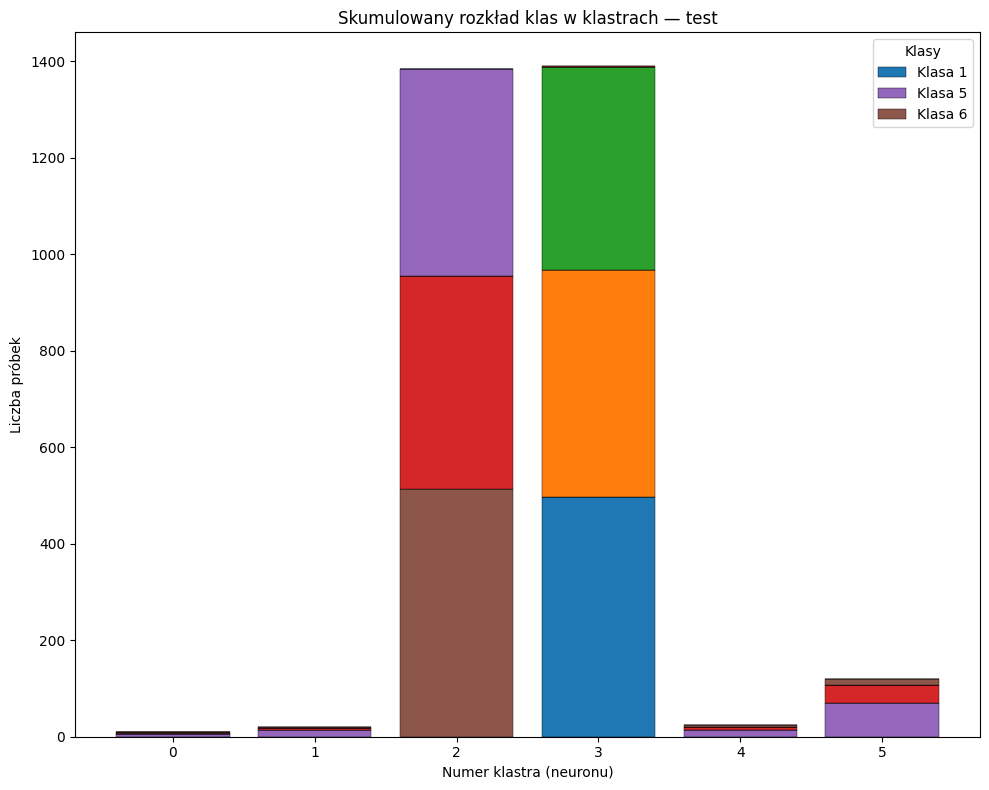

In [41]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.5439336235038085
Liczba klastrów: 17
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


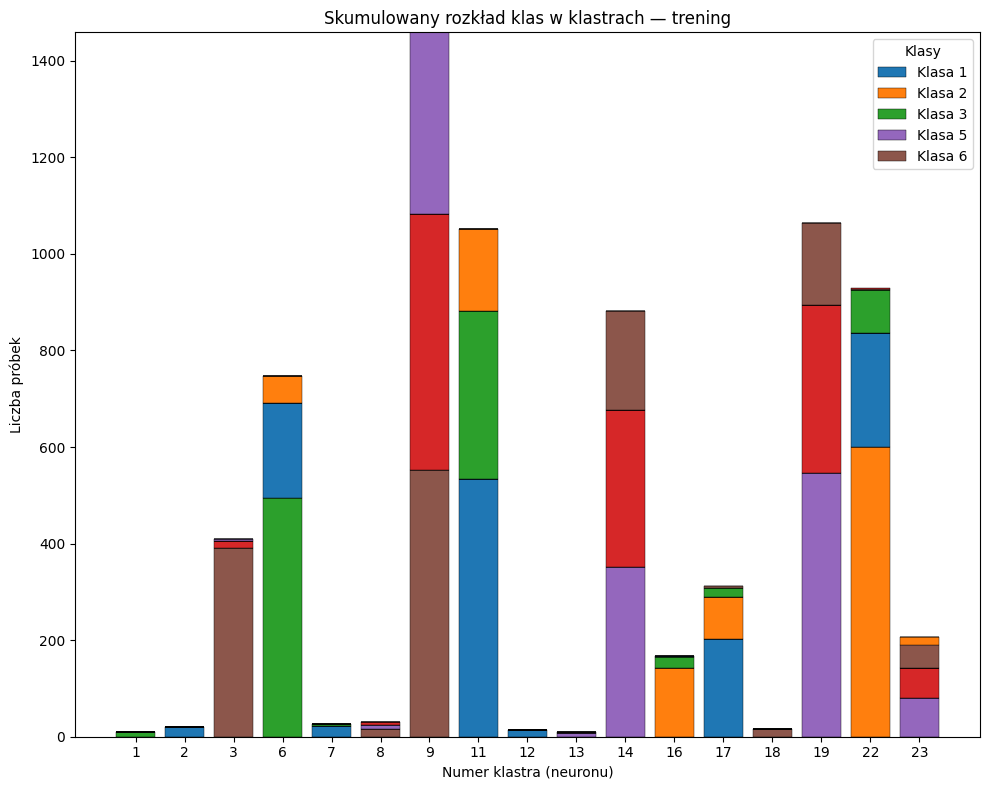

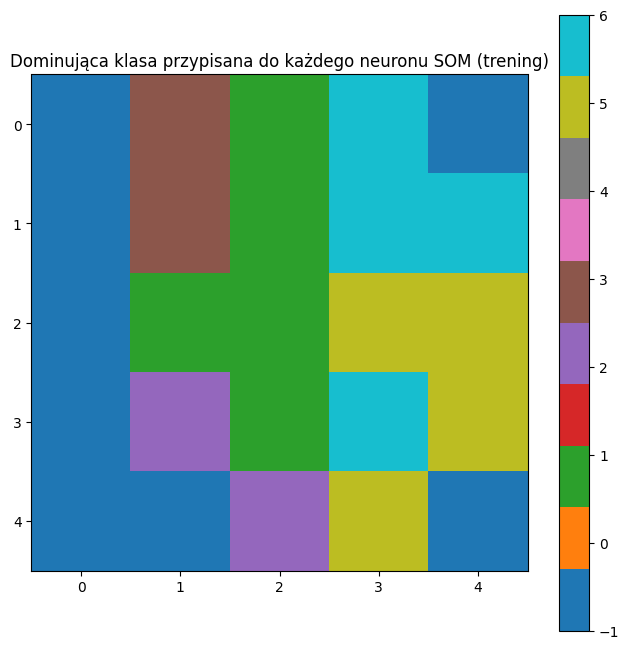

Accuracy na zbiorze testowym: 0.5826263997285375


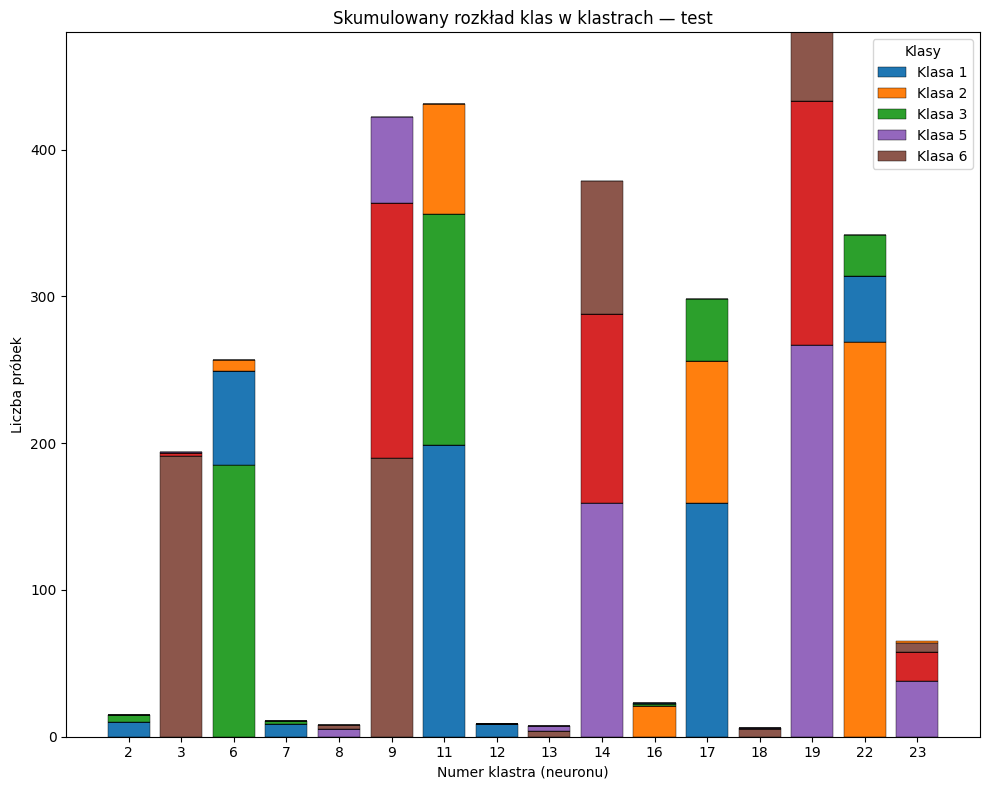

In [42]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.530739934711643
Liczba klastrów: 14
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


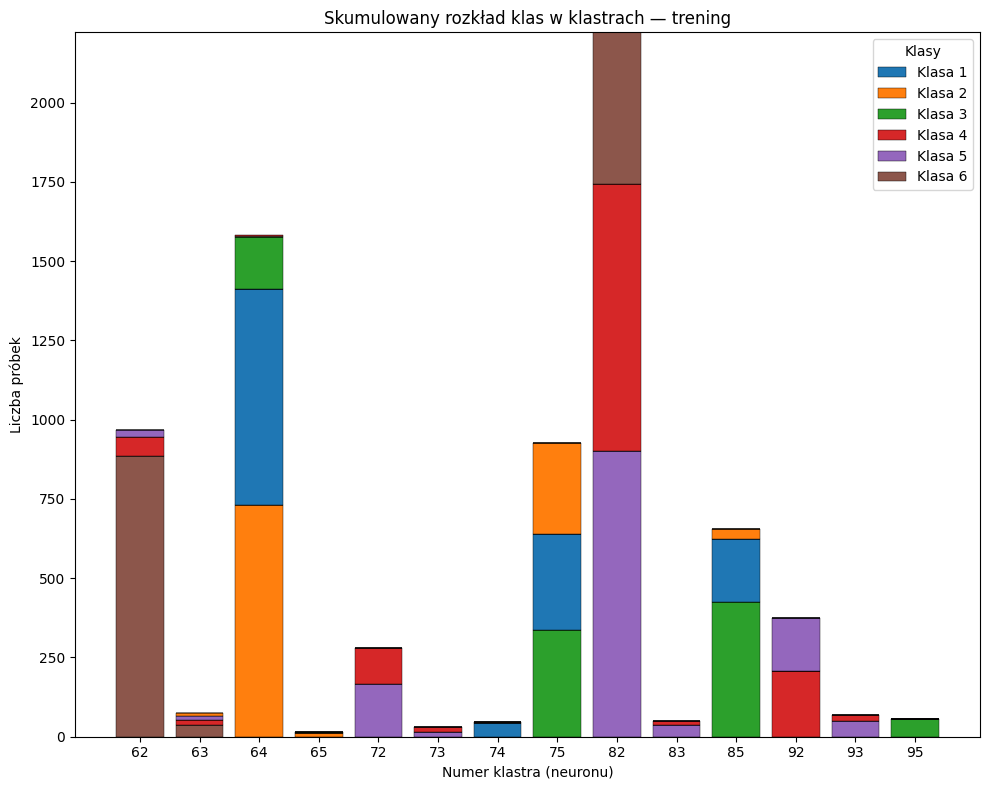

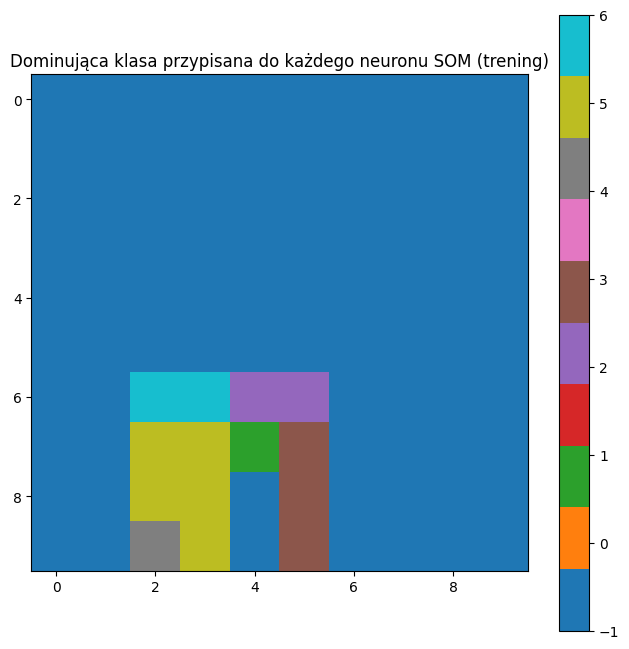

Accuracy na zbiorze testowym: 0.5480149304377333


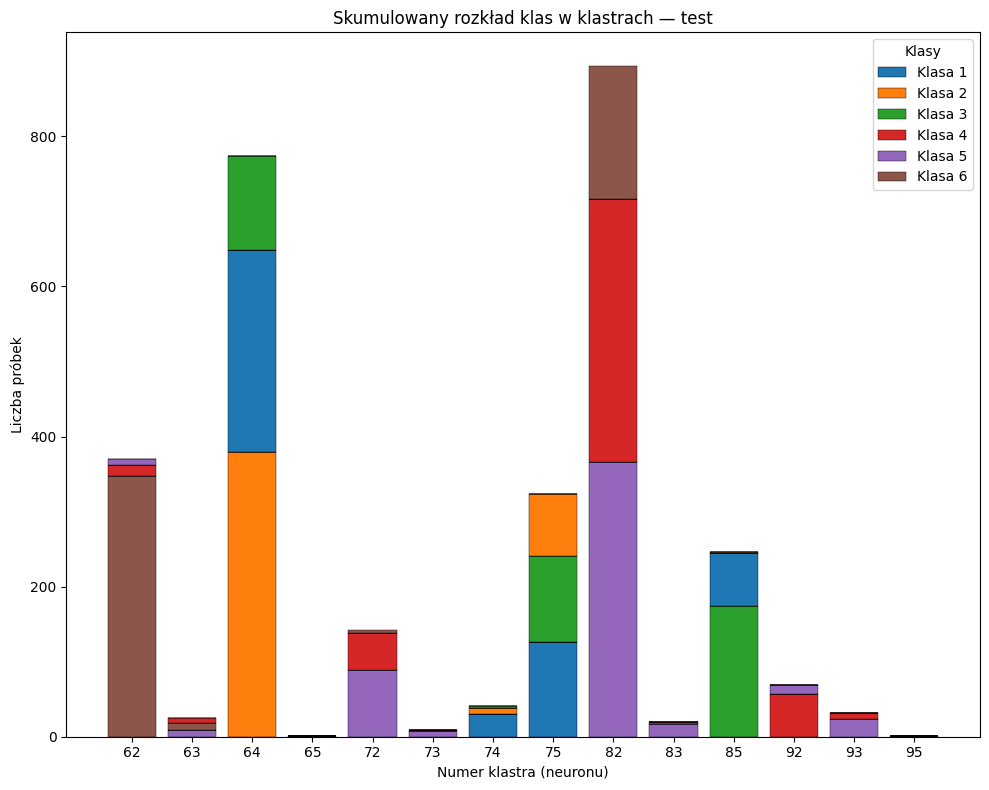

In [43]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=10, N=10, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.5749455930359086
Liczba klastrów: 18
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


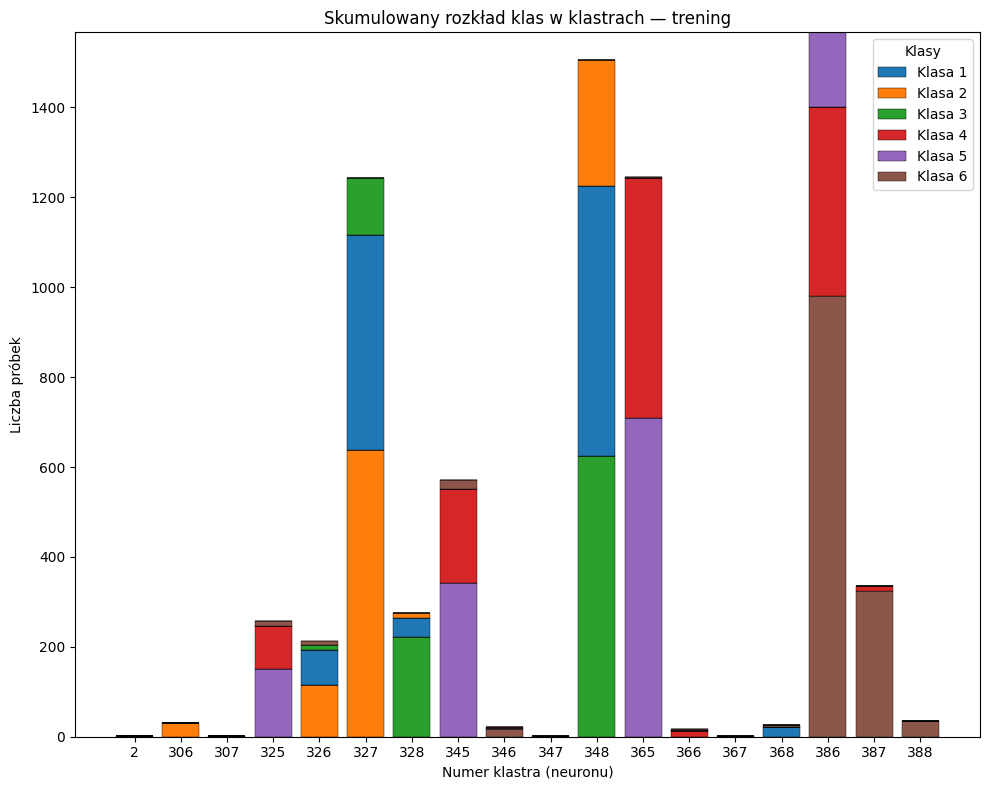

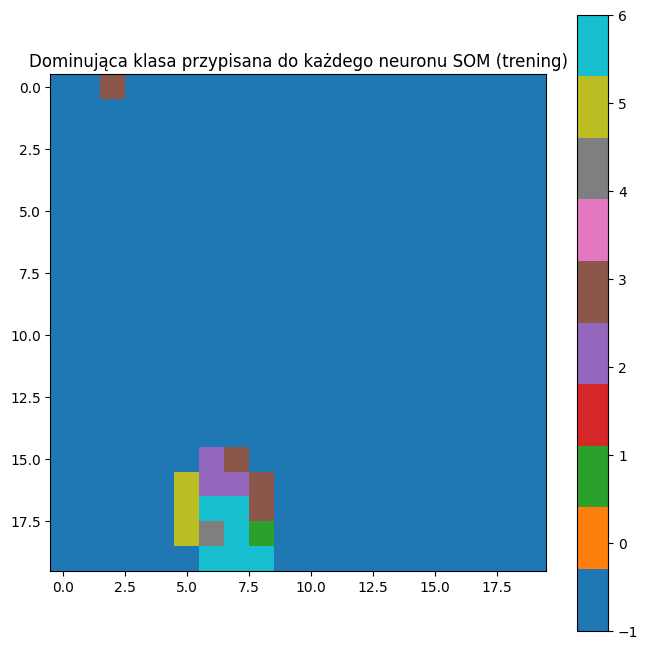

Accuracy na zbiorze testowym: 0.6148625721072277


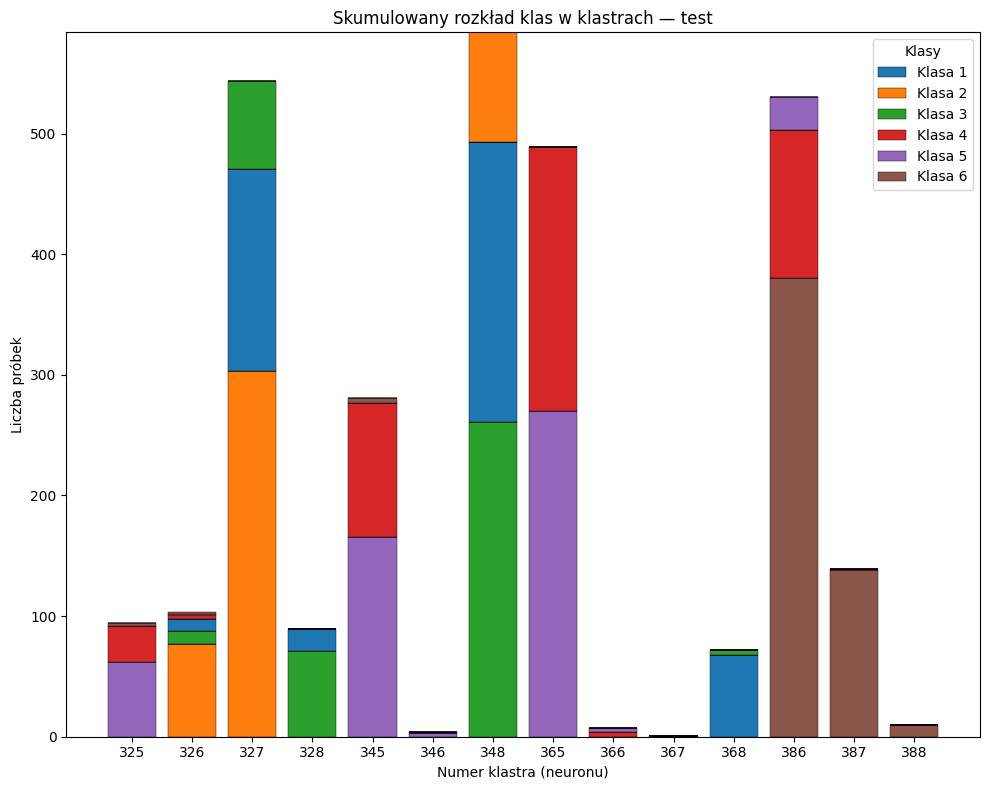

In [54]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=20, N=20, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='matrix')

show_results(network, X, y, X_test, y_test)

| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| Minus 2-gauss      | matrix    | 3     | 2x3            | 0.3735         | 0.3767        | 6              |
| Minus 2-gauss      | matrix    | 3     | 5x5            | 0.5439         | 0.5826        | 17             |
| Minus 2-gauss      | matrix    | 3     | 10x10          | 0.5307         | 0.5480        | 14             |
| Minus 2-gauss      | matrix    | 3     | 20x20          | 0.5749         | 0.6149        | 18             |

### second_derivative_gaussian, hex, 2x3,5x5,10x10, 20x20

Dopasowana accuracy (trening): 0.37704026115342765
Liczba klastrów: 6
Liczba klas: 6
Liczba klastrów pokrywa się z liczbą klas.


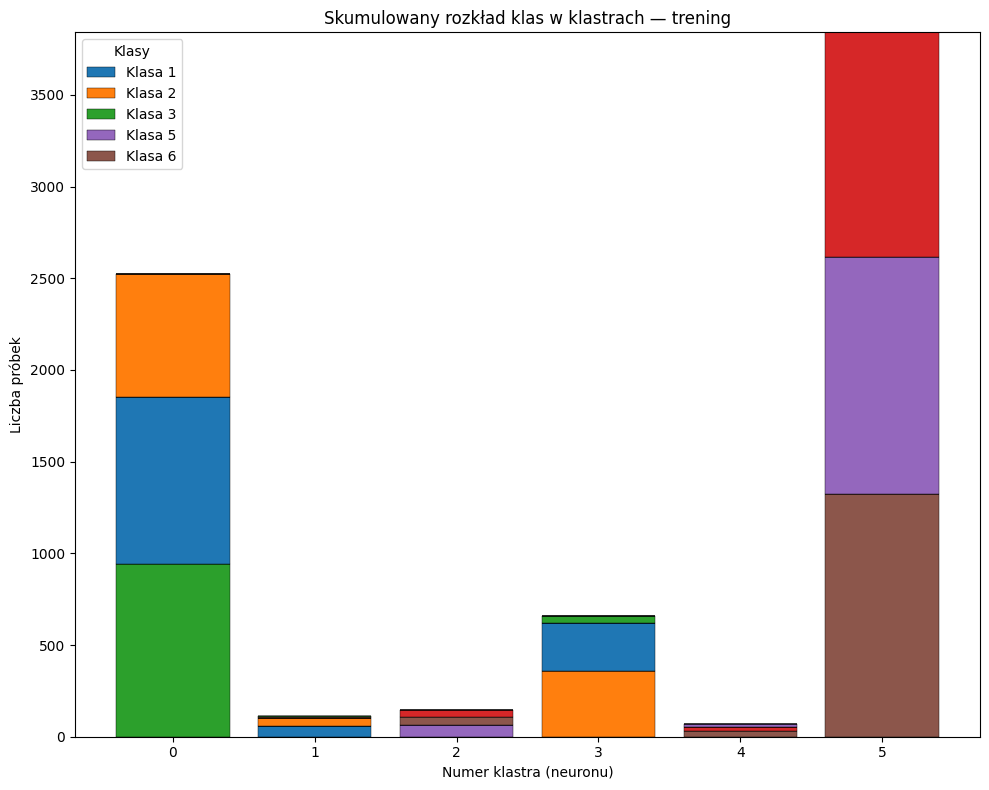

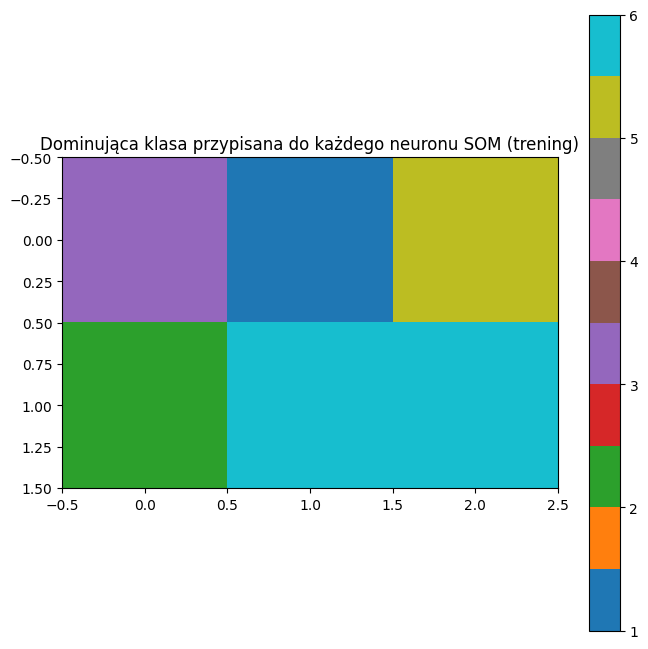

Accuracy na zbiorze testowym: 0.38615541228367833


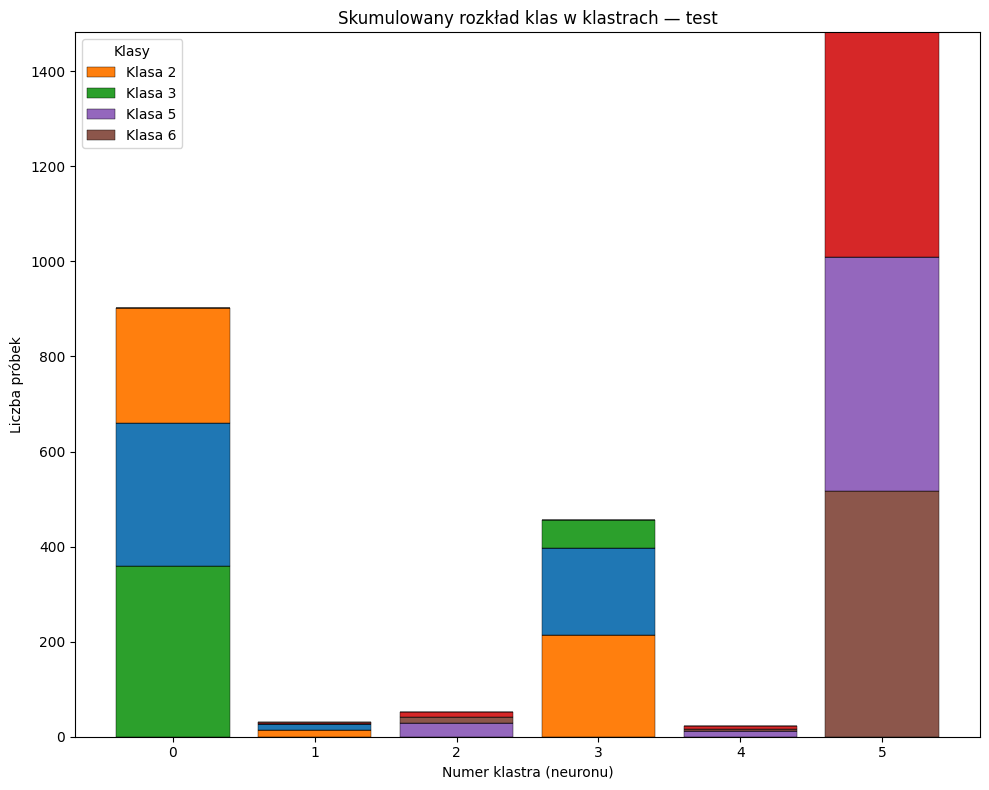

In [44]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=2, N=3, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.46259521218715993
Liczba klastrów: 13
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


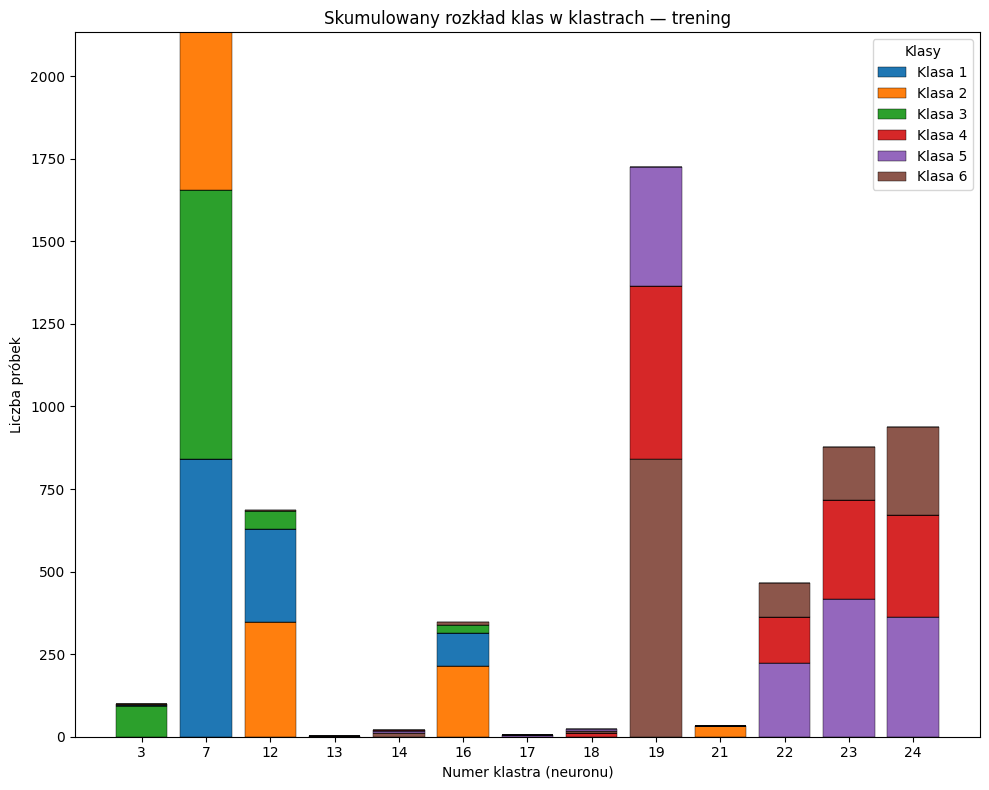

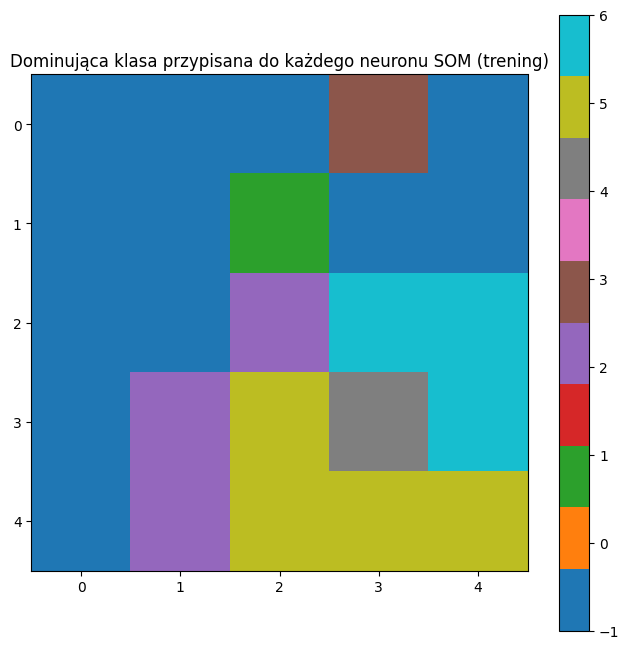

Accuracy na zbiorze testowym: 0.4855785544621649


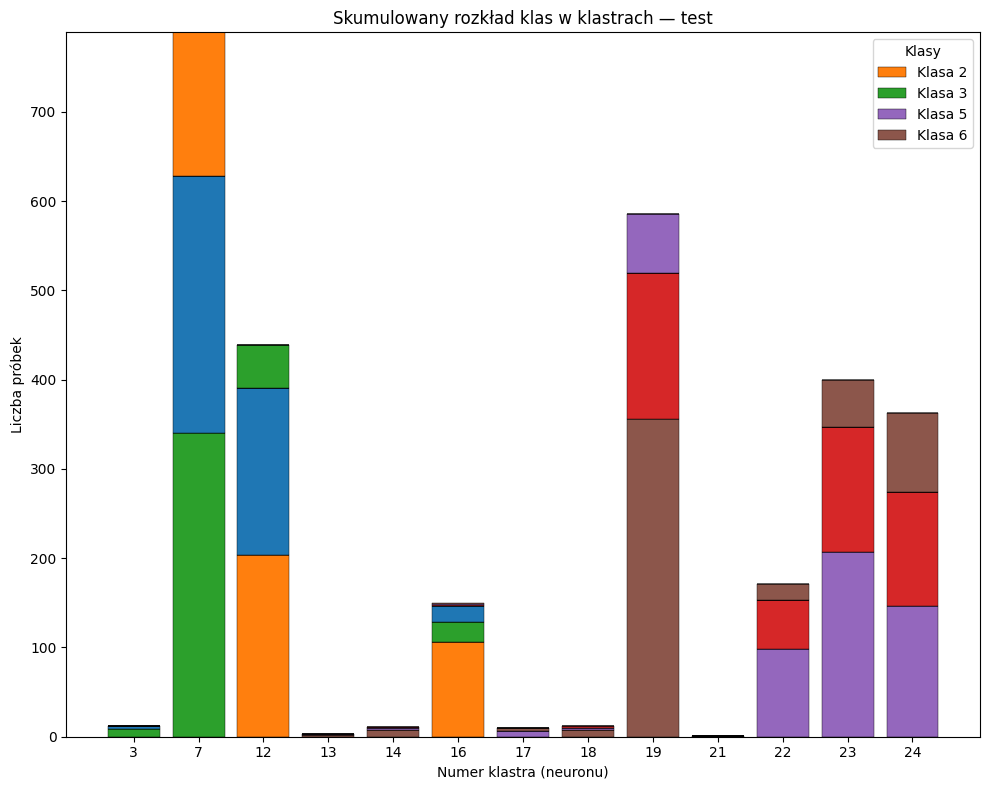

In [45]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=5, N=5, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.6668933623503809
Liczba klastrów: 17
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


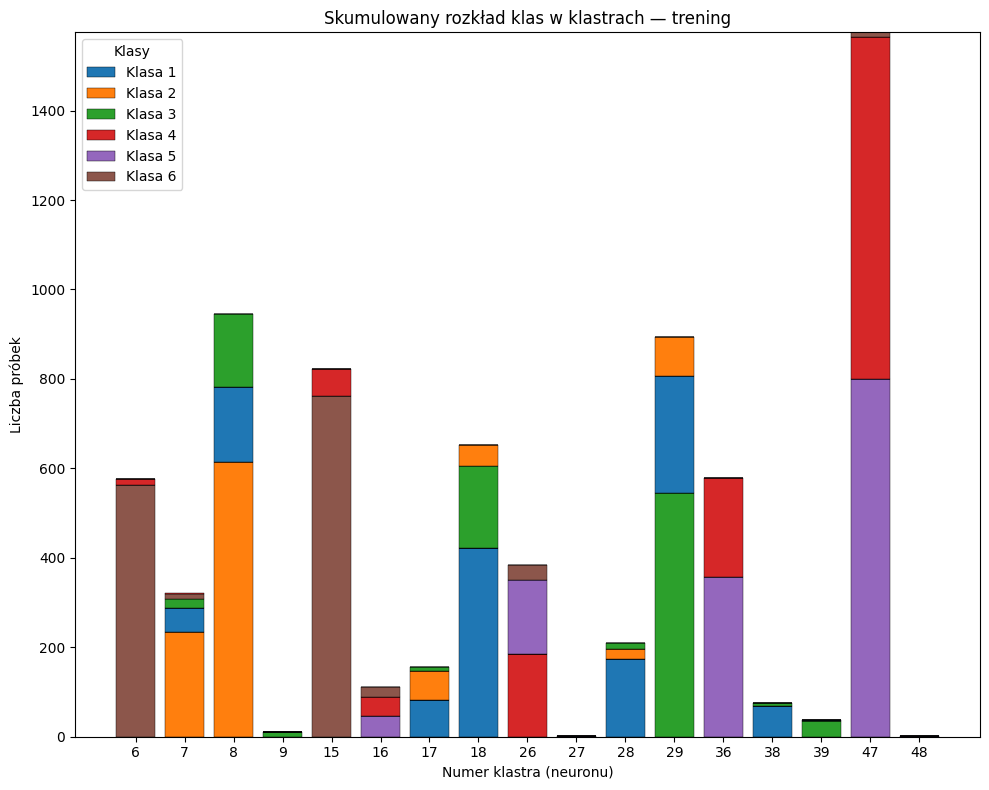

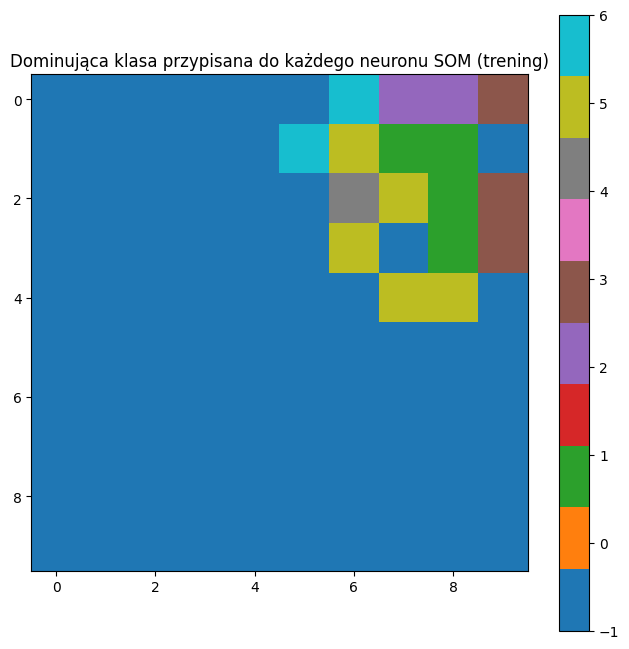

Accuracy na zbiorze testowym: 0.6454021038344079


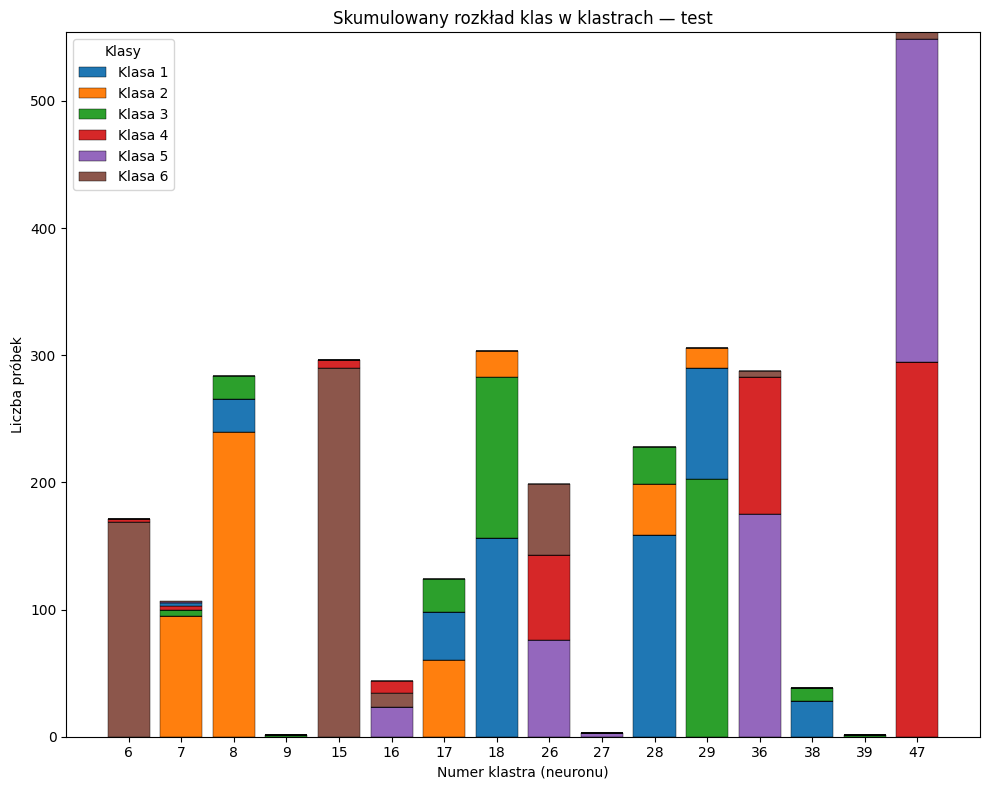

In [46]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=10, N=10, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

Dopasowana accuracy (trening): 0.5497823721436343
Liczba klastrów: 15
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.


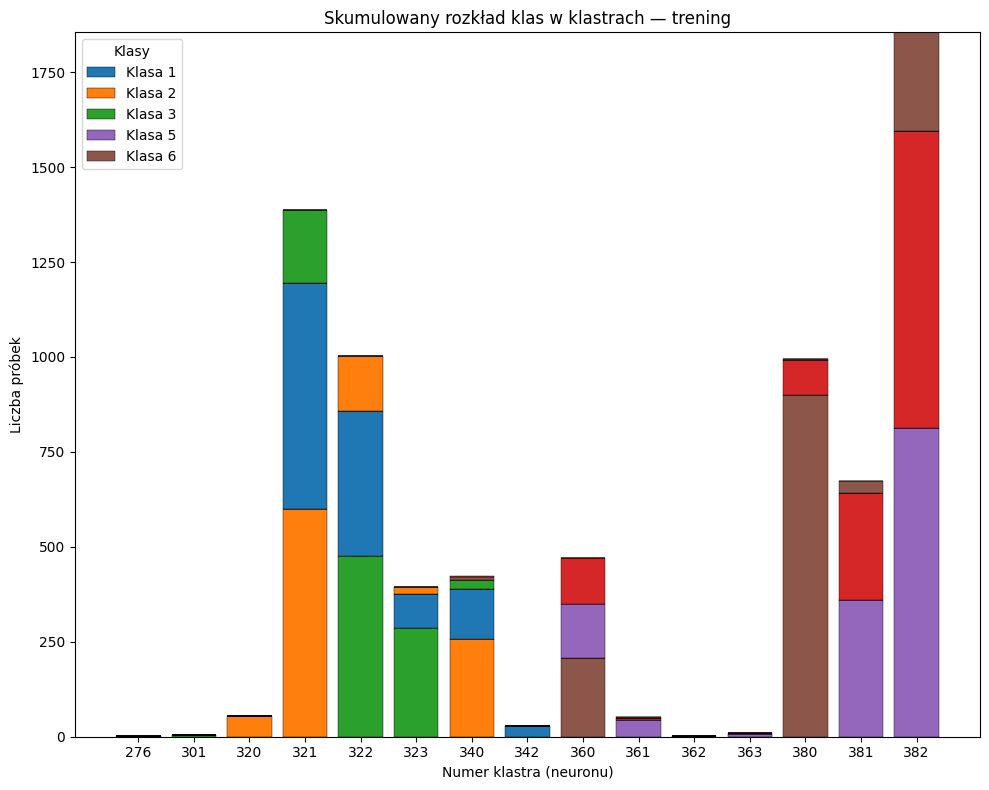

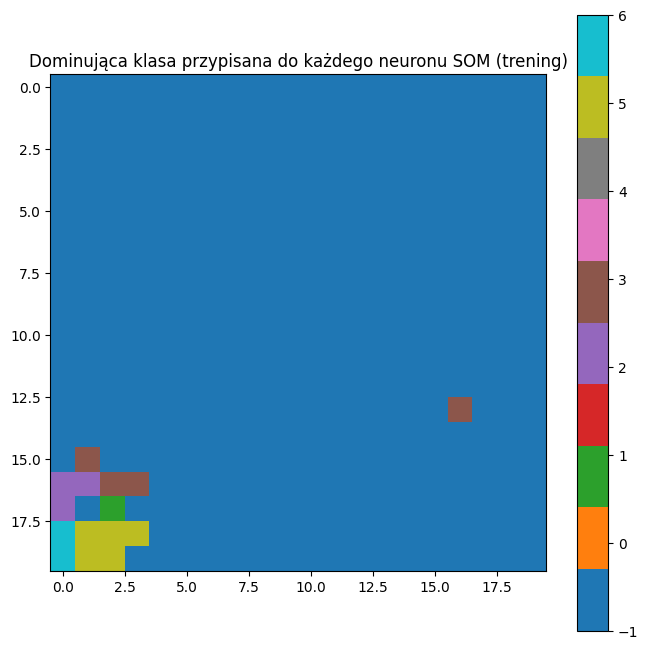

Accuracy na zbiorze testowym: 0.5493722429589413


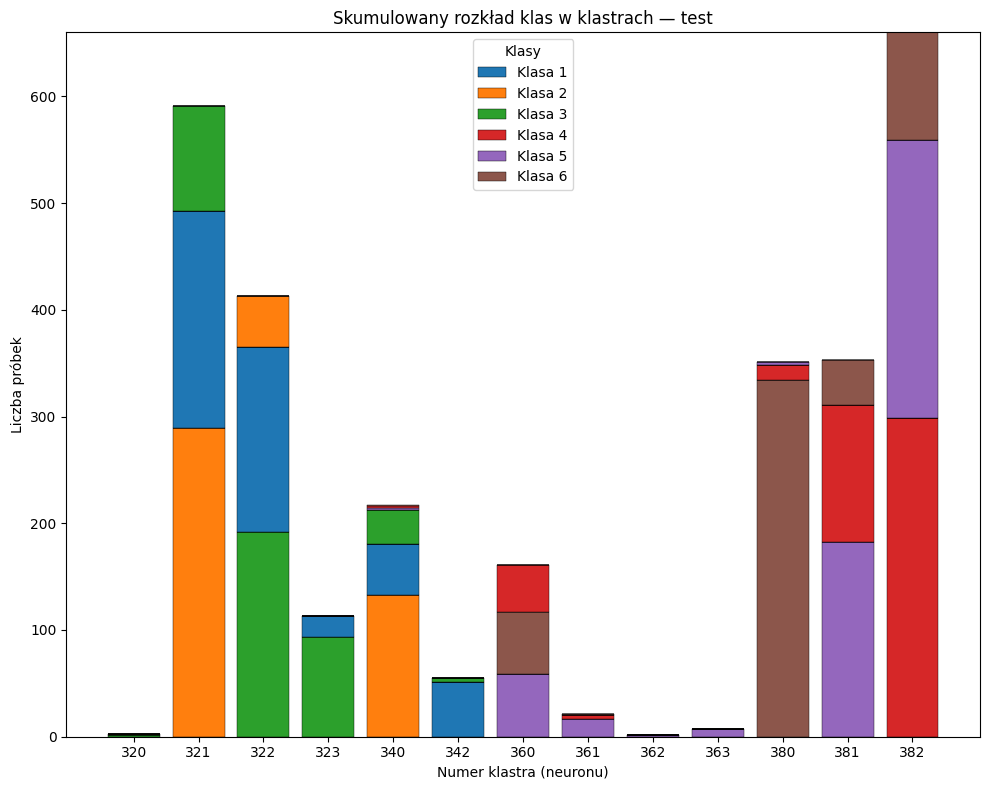

In [55]:
X = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None).values
y = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()

X_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None).values
y_test = pd.read_csv("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

network = KohonenNetwork(M=20, N=20, input_dim=561, neighborhood_function="second_derivative_gaussian", sigma = 3)

network.train(X, epochs=1000, topology_type='hex')

show_results(network, X, y, X_test, y_test)

| Funkcja sąsiedztwa | Topologia | Sigma | Rozmiar siatki | Accuracy Train | Accuracy Test | Ilość klastrów |
|--------------------|-----------|-------|----------------|----------------|---------------|----------------|
| Minus 2-gauss      | hex       | 3     | 2x3            | 0.3770         | 0.3862        | 6              |
| Minus 2-gauss      | hex       | 3     | 5x5            | 0.4626         | 0.4856        | 13             |
| Minus 2-gauss      | hex       | 3     | 10x10          | 0.6669         | 0.6454        | 17             |
| Minus 2-gauss      | hex       | 3     | 20x20          | 0.5498         | 0.5494        | 15             |